# Demonstrating the optDMD and BOP-DMD using a simple example.

Bagging-Optimized Dynamic Mode Decomposition (BOP-DMD) and Optimized Dynamic Mode Decomposition (optDMD)

Citations:

- **optimized Dynamic Mode Decomposition (optDMD)**: Askham, T., & Kutz, J. N. (2018). Variable projection methods for an optimized dynamic mode decomposition. SIAM Journal on Applied Dynamical Systems, 17(1), 380–416. https://doi.org/10.1137/M1124176

- **Bagging, Optimized Dynamic Mode Decomposition (BOP-DMD)**: Sashidhar, D., & Kutz, J. N. (2022). Bagging, optimized dynamic mode decomposition for robust, stable forecasting with spatial and temporal uncertainty quantification. Philosophical Transactions of the Royal Society A: Mathematical, Physical and Engineering Sciences, 380(2229). https://doi.org/10.1098/rsta.2021.0199

## Details

Both the optDMD and BOP-DMD were previously only matlab implementations. The focus of this notebook is the implementation and testing of crude python translations.

1) optDMD: Provides an optimized framework for solving the DMD regressions that may come from unevenly spaced time snapshots. 

2) The BOP-DMD takes advantage of this property and solves the DMD using statistical bagging (i.e., randomly selected ensembles) for constructing the DMD.

The advantage of the combined BOP-DMD is: (a) the additional ability to provide uncertainty estimates in the DMD solutions, especially the uncertainty in the spatial modes, (b) the ability to better represent the time dynamics for more complex systems such as those commonly found in geophysics, and (c) robustly solving the DMD for noisy data.

It takes several minutes to run the notebook due to the number of noisy realizations and the size of the ensembles. This version of the BOP-DMD discards certain ensemble members with poor properties, see `BOP-DMD.debug-noisy-data.ipynb` for details.

# Setup

## Imports

In [1]:
# netcdf/numpy/xray/stats
import numpy as np
import xarray as xr
import pandas as pd
import pydmd
from pydmd.bopdmd import BOPDMD
import colorednoise as cn

# OS interaction
import os
import sys

# import plotting
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.dates import DateFormatter


The optDMD raises several warnings. They are disabled by the below lines to make the output of the examples cleaner, but there are several points that need to be cleaned up.

-> This may be no longer necessary due to using the pydmd classes

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from pyoptdmd import optimalDMD
from pyoptdmd import bop_dmd as kl_bopdmd

## Format plots

In [4]:
%matplotlib inline
# Higher resolution figures within the notebook
%config InlineBackend.figure_format = 'retina'

# Set the plot style from the seaborn library
sns.set_style("whitegrid")
sns.set_context('paper')

# Tol bright color scheme reordered to put my favorite colors first
tol_bright_reorder = [
    '#4477AA',
    '#CCBB44',
    '#EE6677',
    '#228833',
    '#66CCEE',
    '#AA3377',
    '#BBBBBB'
]
sns.set_palette(sns.color_palette(tol_bright_reorder))

# Helper functions

## xarray containers for ensemble results

This is not strictly necessary, but xarray is a nice data container that enables easier exploration of ensemble results.

In [5]:
def build_ensemble_xarray(data, ds_previous=None, num_eigenvalues=3,
                          column_name='ensemble member',
                          concat_dim='cycle', variable_name='eigenvalue'):
    """Convert the results to an xarray Dataset.
    
    Dataset has coordinates of index (a melt of eigenvalue and ensemble member) 
    and cycle (number of ensembles created). The cycle dimension is the dimension
    along which ensembles are stacked in the concatenation.
    """
    
    # Build the eigenvalues dimension
    eigenvalues_coord = [str(k) for k in np.arange(1, num_eigenvalues + 1)]
    
    # Convert to a Pandas dataframe to use the melt function.
    # Build the real component
    df_real = pd.DataFrame(
        data=data.real,
    )

    df_real[variable_name] = eigenvalues_coord
    df_real.columns.names = [column_name]

    df_real = pd.melt(df_real, id_vars=variable_name, value_name='real')

    mi = pd.MultiIndex.from_frame(df_real[[column_name, variable_name]])
    df_real.index = mi
    df_real = df_real.drop([column_name, variable_name], axis=1)

    # Build the imaginary component.
    df_imag = pd.DataFrame(
        data=data.imag,
    )

    df_imag[variable_name] = eigenvalues_coord
    df_imag.columns.names = [column_name]

    df_imag = pd.melt(df_imag, id_vars=variable_name, value_name='imag')

    mi = pd.MultiIndex.from_frame(df_imag[[column_name, variable_name]])
    df_imag.index = mi
    df_imag = df_imag.drop([column_name, variable_name], axis=1)

    # Concatenate the real and imaginary components into a single Dataframe.
    df = pd.concat(
        [df_real, df_imag], axis=1
    )

    # Convert to xarray since this better handles the multidimensional data.
    ds = xr.Dataset.from_dataframe(df)
    if ds_previous is None:
        ds = ds
    else:
        ds = xr.concat([ds_previous, ds], dim=concat_dim)
    return ds

## Evaluation plots

A helper plotting function to simplify making the same plot for each test.

In [6]:
def eigenvalue_scatterplot(ds_plot, true_eigenvalues, lims=(-3, 3)):
    """Distribution of eigenvalues using a seaborn jointplot.
    
    """
    
    g = sns.scatterplot(
        data=ds_plot.to_dataframe(),
        x="real",
        y="imag",
        hue='eigenvalue',
        marker='D',
        legend=False,
    )

    for nk, k in enumerate(ds_plot.eigenvalue):
        ds = ds_plot.sel(eigenvalue=k)
        ds_mean = ds.mean(dim='noise realization')
        
        # Errorbars for each noise realization across the entire ensemble
        if 'real_std' in ds_plot.data_vars:
            g.errorbar(
                ds['real'],
                ds['imag'],
                xerr=ds['real_std'],
                yerr=ds['real_std'],
                fmt='none',
                color=tol_bright_reorder[nk],
                zorder=0,
                alpha=0.5,
            )
        
        # Mean across all realizations
        g.scatter(
            ds_mean['real'],
            ds_mean['imag'],
            50,
            color=tol_bright_reorder[nk],
            marker='s',
            edgecolor='k',
            linewidth=1,
        )

    for nte, te in enumerate(true_eigenvalues):
        g.scatter(
            np.real(te),
            np.imag(te),
            50,
            color=tol_bright_reorder[nte],
            marker='o',
            edgecolor='k',
            linewidth=1,
        )
    
    legend_elements = [
        Line2D(
            [0], [0], color='0.5', marker='D', ls='None',
            label='Individual Ensembles'),
        Line2D(
            [0], [0], color='0.5', marker='o', markeredgecolor='k',
            ls='None', label='True Eigenvalues'),
        Line2D(
            [0], [0], color='0.5', marker='s', markeredgecolor='k',
            ls='None', label='Mean of realizations'),
    ]
    g.legend(handles=legend_elements, loc='upper right')
    g.set_aspect('equal')
    g.set(xlim=lims, ylim=lims)
    
    return g

## Relative Error

In [7]:
def relative_error(xprime, x):
    return np.linalg.norm(xprime - x) / np.linalg.norm(x)

## Create toy data

In [8]:
def simple_example(spatial_modes, eigenvalue_array, ts, phase):
    x = np.zeros((spatial_modes[0].size, ts.size), np.complex128)
    for sp, e, c in zip(spatial_modes, eigenvalue_array, phase):
        x += sp.dot(np.exp(e * ts + c * 1j))
    return x

## Driver for Fitting Noisy Realizations

In [9]:
def run_noisy_realizations(
    data, ts, sigma_array, num_noise_cycles, num_ensembles,
    ensemble_size, true_eigs, seed=1, ts_longterm=None,
    data_longterm=None, verbose=False, red_noise=False, num_modes=3): 

    # Set the random seed
    rng = np.random.default_rng(seed)

    # Substantiate the dataset variables.
    ds_optdmd = None
    ds_entire_ensemble_bopdmd = None
    ds_std_bopdmd = None
    ds_mean_bopdmd = None

    optdmd_container = {}
    bopdmd_container = {}

    for sigma in sigma_array:
        if verbose:
            print('')
            print('======================')
            print('sigma={}\n'.format(sigma))

        # Create containers for the eigenvalues
        e_optDMD = np.zeros((num_modes, num_noise_cycles)).astype(complex)
        e_mean_BOPDMD = np.zeros((num_modes, num_noise_cycles)).astype(complex)
        e_std_BOPDMD = np.zeros((num_modes, num_noise_cycles))

        optdmd_container[sigma] = []
        bopdmd_container[sigma] = []

        for k in range(num_noise_cycles):
            if verbose:
                print(
                    'Working on realization {} out of {} total noisy realizations.'.format(
                        k + 1,
                        num_noise_cycles
                    ),
                )

            # Create data for noise cycle by adding random noise to both the imaginary
            # and real components of the input data.
            
             # Add red noise to the input data.
            if red_noise:
                # The exponent for red noise
                beta = 2
                # Th number of samples to generate (aka the length of the time dimension)
                samples = data.shape[1]
                
                if np.iscomplex(data).any():
                    # Noise is generated for each spatial point in time.
                    rn_r = np.array(
                        [
                            cn.powerlaw_psd_gaussian(beta, samples, random_state=rng)
                            for _, _ in enumerate(range(data.shape[0]))
                        ]
                    )
                    rn_i = np.array(
                        [
                            cn.powerlaw_psd_gaussian(beta, samples, random_state=rng)
                            for _, _ in enumerate(range(data.shape[0]))
                        ]
                    )

                    # Scale the red noise to have the same amplitude as the white noise
                    rn_sigma_scaling = np.mean([sigma / rn_r.std(), sigma / rn_i.std()])
                    xdata = (
                        data
                        + rn_sigma_scaling * rn_r
                        + 1j * rn_sigma_scaling * rn_i
                    )
                else:
                    rn_r = np.array([cn.powerlaw_psd_gaussian(beta, samples, random_state=rng) for _, _ in enumerate(data.shape(0))])

                    # Scale the red noise to have the same amplitude as the white noise
                    rn_sigma_scaling = sigma / rn_r.std()
                    xdata = data + rn_sigma_scaling * rn_r

            # Add white noise to the input data
            else:
                if np.iscomplex(data).any():
                    xdata = (
                        data
                        + sigma * rng.standard_normal(data.shape)
                        + 1j * sigma * rng.standard_normal(data.shape)
                    )
                else:
                    xdata = data + sigma * rng.standard_normal(data.shape)

            # Fit the optDMD and BOP-DMD
            e_ensembleDMD, bopdmd_ensemble, e_opt, optdmd = kl_bopdmd.fit(
                xdata, ts, num_modes, num_ensembles=num_ensembles,
                ensemble_size=ensemble_size, seed=seed,
                long_term_mean=data_longterm, long_term_ts=ts_longterm,

            )

            optdmd_container[sigma].append(optdmd)
            bopdmd_container[sigma].append(bopdmd_ensemble)

            # Match the eigenvalues to the true ones using the Munkres algorithm.
            _, indices = kl_bopdmd.match_vectors(e_opt, true_eigs)
            e_optDMD[:, k] = e_opt[indices]

            # The eigenvalues are matched to the optDMD eigenvalues, but these orders
            # may differ between realizations depending on the optDMD solution. Re-sort
            # the eigenvalues here relative to the true eigenvalues for the sake of comparison.
            for n in range(e_ensembleDMD.shape[1]):
                e = e_ensembleDMD[:, n]
                if np.isnan(e).any():
                    continue
                else:
                    _, indices = kl_bopdmd.match_vectors(e_ensembleDMD[:, n], true_eigs)
                    e_ensembleDMD[:, n] = e_ensembleDMD[indices, n]

            e_mean_BOPDMD[:, k] = np.nanmean(e_ensembleDMD, 1)
            e_std_BOPDMD[:, k] = np.nanstd(e_ensembleDMD, 1)
            relerr_e = (
                np.linalg.norm(e_mean_BOPDMD[:, k] - true_eigs, 2)
                / np.linalg.norm(true_eigs, 2)
            )

            if verbose:
                print('------------------------------')
                print('Mean Eigenvalues Error {:.4f}'.format(relerr_e))
                print('std Eigenvalues:'.format())
                print(e_std_BOPDMD[:, k])
                print('------------------------------')
                print()

        # Build the xarray containers for the results of each noise realization.

        # First, build the optdmd results container.
        ds_optdmd = build_ensemble_xarray(
            e_optDMD,
            ds_previous=ds_optdmd,
            column_name='noise realization',
            concat_dim='sigma',
            num_eigenvalues=num_modes,
        )

        # Second, build the containers for the mean and standard deviation of the BOP-DMD. 
        ds_mean_bopdmd = build_ensemble_xarray(
            e_mean_BOPDMD,
            ds_previous=ds_mean_bopdmd,
            variable_name='eigenvalue',
            column_name='noise realization',
            concat_dim='sigma',
            num_eigenvalues=num_modes,
        )

        ds_std_bopdmd = build_ensemble_xarray(
            e_std_BOPDMD,
            ds_previous=ds_std_bopdmd,
            variable_name='eigenvalue',
            column_name='noise realization',
            concat_dim='sigma',
            num_eigenvalues=num_modes,
        )

    # Clean up variables and labels.
    new_names = {dv: dv + '_std' for dv in ds_std_bopdmd.data_vars}
    ds_std_bopdmd = ds_std_bopdmd.rename_vars(new_names)
    ds_mean_bopdmd.coords['sigma'] = sigma_array
    ds_std_bopdmd.coords['sigma'] = sigma_array
    ds_bopdmd = xr.merge([ds_mean_bopdmd, ds_std_bopdmd])
    ds_optdmd.coords['sigma'] = sigma_array
    
    return ds_optdmd, ds_bopdmd, optdmd_container, bopdmd_container


## Certainty Donut

In [10]:
def certainty_donut(radii):
    """Plots the eigenvalue certainty donut
    
    https://stackoverflow.com/questions/22789356/plot-a-donut-with-fill-or-fill-between-use-pyplot-in-matplotlib
    
    """
    
    n = 50
    theta = np.linspace(0, 2*np.pi, n, endpoint=True)
    xs = np.outer(radii, np.cos(theta))
    ys = np.outer(radii, np.sin(theta))

    # in order to have a closed area, the circles
    # should be traversed in opposite directions
    xs[1,:] = xs[1,::-1]
    ys[1,:] = ys[1,::-1]
    
    xs = np.ravel(xs)
    ys = np.ravel(ys)
    
    return xs, ys

# Example Data

## Modified example with oscillating modes

+ 2 oscillating modes with no decay/growth
+ 1 slowly decaying, oscillating mode that is not fully resolved

In [11]:
# Generate the synthetic data.

# Set up modes in space.
x0 = 0
x1 = 2 * np.pi
nx = 200

# Space component is evenly spaced.
xspace = np.linspace(x0,x1,nx)

# Set up the spatial modes
f1 = np.sin(xspace)[:, np.newaxis]
f2 = np.cos(xspace)[:, np.newaxis]
f3 = np.tanh(xspace)[:, np.newaxis]

# Set up the time dimension.
t0 = 0
t1 = 0.25
t2 = t1 + t1 * 0.1
t_extended = int(t1 * 10)
num_timesteps_per_1s = 500
nt = int(num_timesteps_per_1s * t1)

ts = np.linspace(t0, t1, nt, endpoint=False)[np.newaxis, :]
ts_forecast = np.linspace(t1, t2, nt // 10, endpoint=False)[np.newaxis, :]
ts_extended = np.linspace(t0, t_extended, t_extended * num_timesteps_per_1s, endpoint=False)[np.newaxis, :]

# Temporal eigenvalues for each mode
e1 = -2.5 + 10j
e2 = 0 + 23j
e3 = 0 - 17j
true_eigenvalues = np.array([e1, e2, e3])
# Phase offset of the temporal modes
phase = [0, 0, -np.pi]


# Generate the clean, noiseless dynamics.
xclean = simple_example([f1, f2, f3], true_eigenvalues, ts, phase)
xclean_extended = simple_example([f1, f2, f3], true_eigenvalues, ts_extended, phase)
xclean_forecast = simple_example([f1, f2, f3], true_eigenvalues, ts_forecast, phase)

## Visualize

Text(0.5, 0, 'Time Dimension')

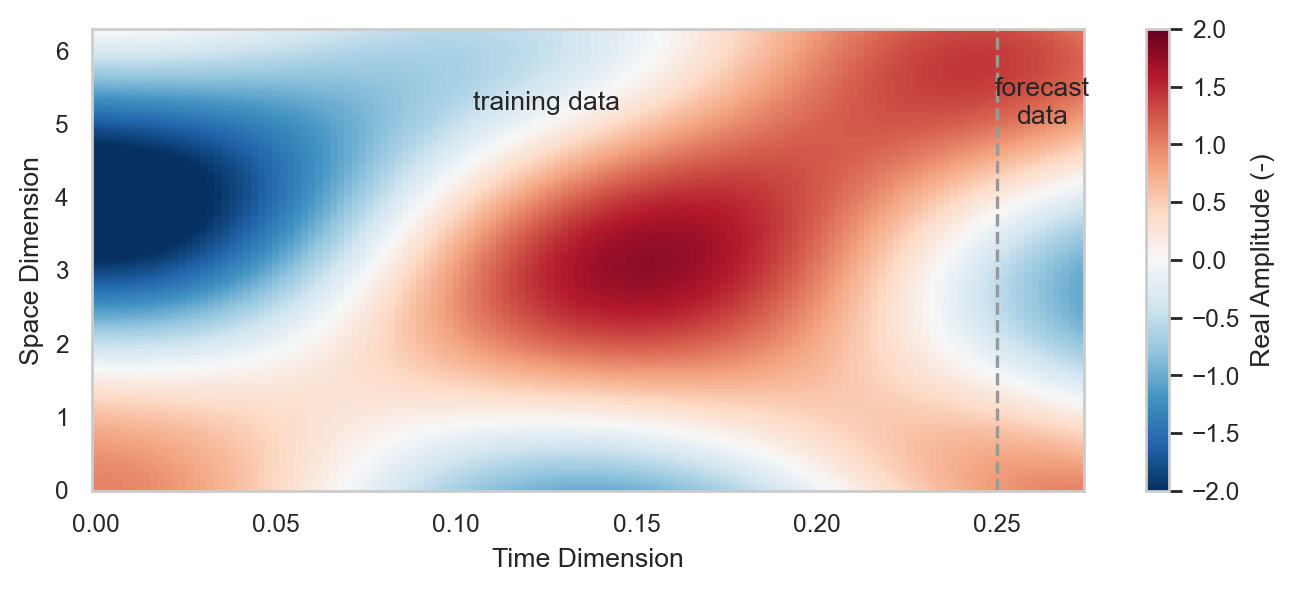

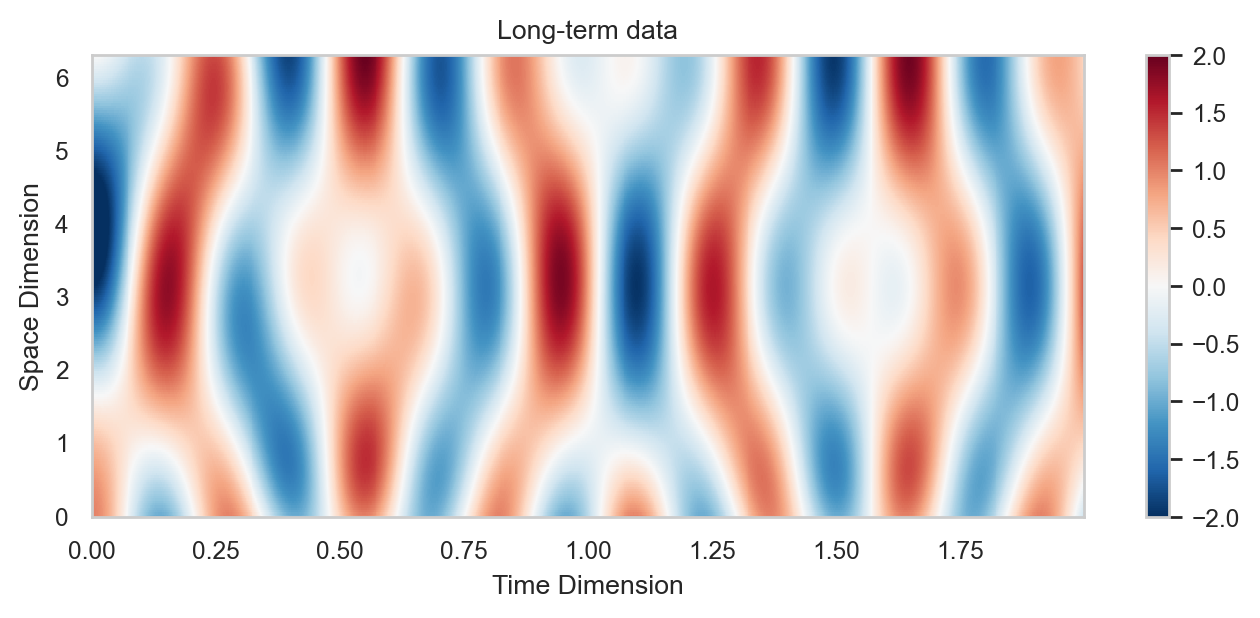

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
c = ax.pcolormesh(ts, xspace, np.real(xclean), vmin=-2, vmax=2, cmap='RdBu_r')
ax.pcolormesh(ts_forecast, xspace, np.real(xclean_forecast), vmin=-2, vmax=2, cmap='RdBu_r')
ax.text(t0 + (t1 - t0) / 2, xspace.max() - xspace.max() // 5, 'training data',
        horizontalalignment='center',
        verticalalignment='center',
        transform=ax.transData)
ax.axvline(t1, color='0.6', ls='--')
ax.text(t1 + (t2 - t1) / 2, xspace.max() - xspace.max() // 5, 'forecast\ndata',
        horizontalalignment='center',
        verticalalignment='center',
        transform=ax.transData)
cbar = fig.colorbar(c)
cbar.set_label('Real Amplitude (-)')
# ax.set_title('Simple Example')
ax.set_ylabel('Space Dimension')
ax.set_xlabel('Time Dimension')

fig, ax = plt.subplots(1, 1, figsize=(8, 3))
c = ax.pcolormesh(ts_extended, xspace, np.real(xclean_extended), vmin=-2, vmax=2, cmap='RdBu_r')
fig.colorbar(c)
ax.set_title('Long-term data')
ax.set_ylabel('Space Dimension')
ax.set_xlabel('Time Dimension')


Text(0.5, 1.0, 'Spatial Modes of the Toy Data')

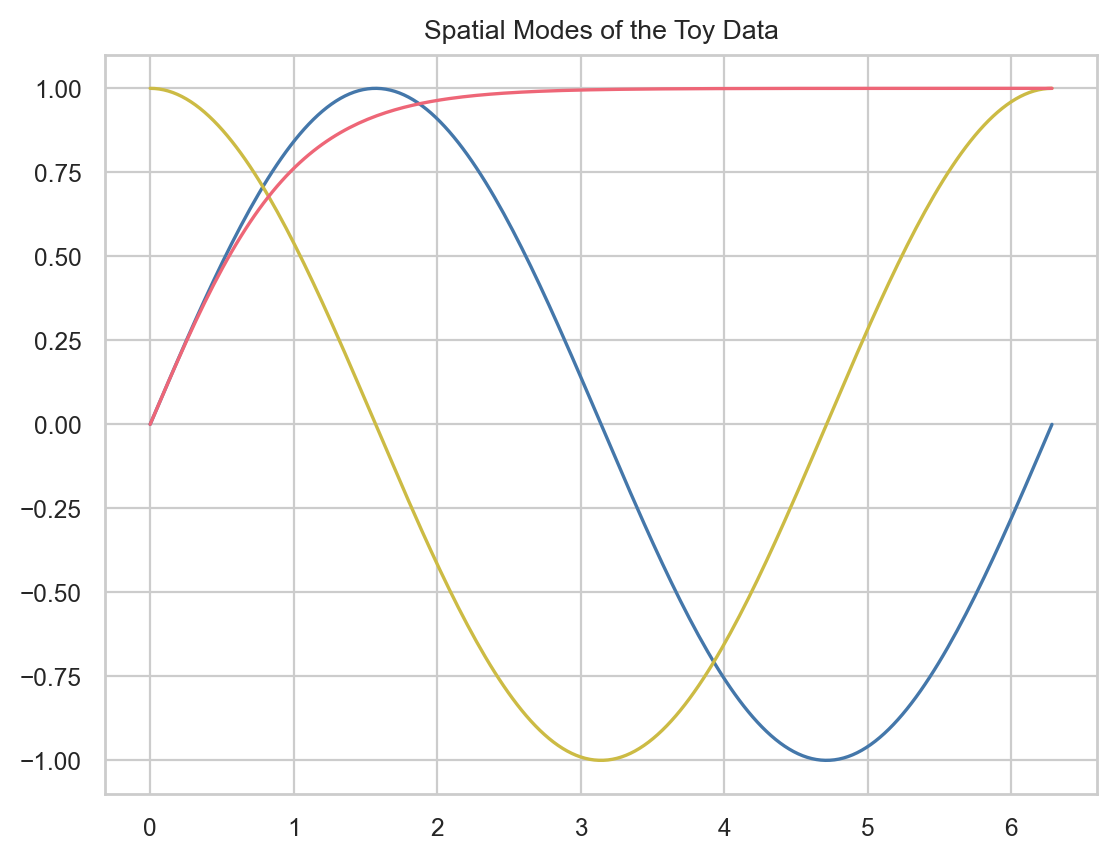

In [13]:
fig, ax = plt.subplots(1, 1)
ax.plot(xspace, f1)
ax.plot(xspace, f2)
ax.plot(xspace, f3)
ax.set_title('Spatial Modes of the Toy Data')

Text(0.5, 1.0, 'Temporal Modes of the Toy Data')

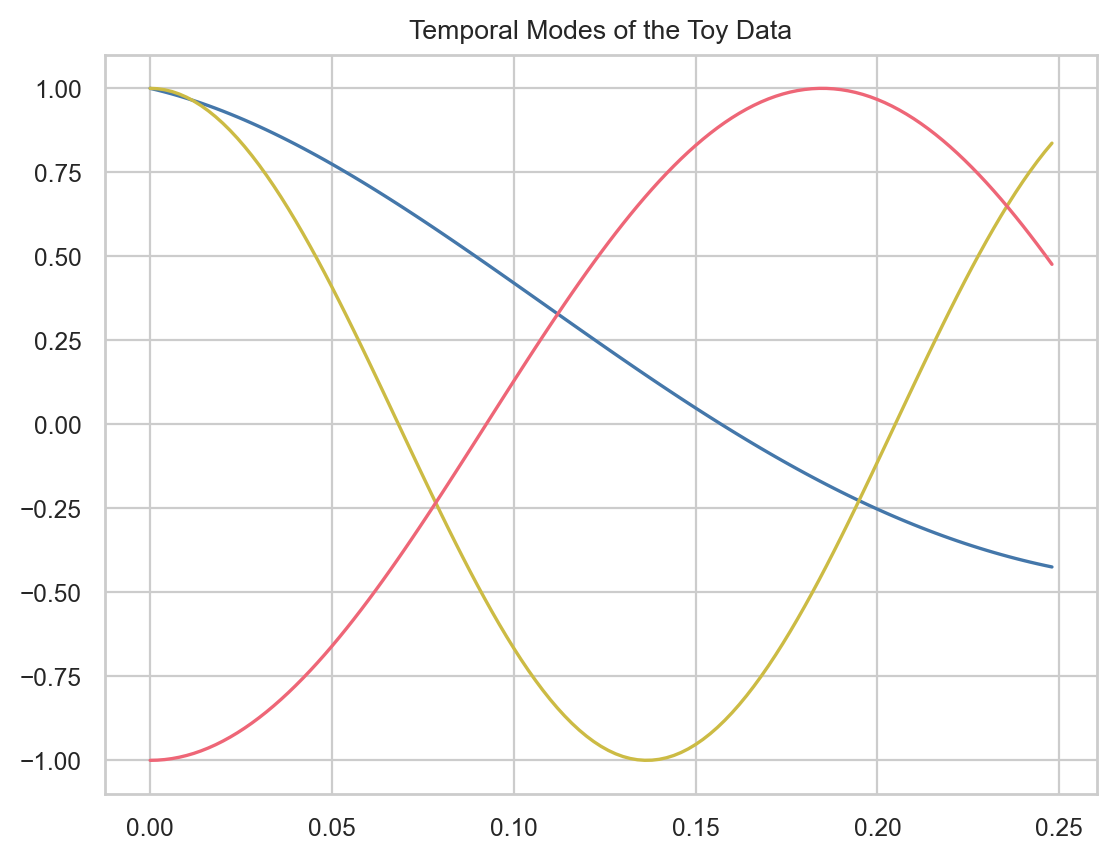

In [14]:
fig, ax = plt.subplots(1, 1)
# ts_plot = np.linspace(t0, 2, nt)[np.newaxis, :]
ax.plot(ts.T, np.real(np.exp(e1 * ts)).T)
ax.plot(ts.T, np.real(np.exp(e2 * ts)).T)
ax.plot(ts.T, np.real(np.exp(e3 * ts - np.pi * 1j)).T)
# ax.plot(ts.T, np.real(np.exp(e3 * ts)).T)
ax.set_title('Temporal Modes of the Toy Data')

## Understand the red noise corruption of the toy data

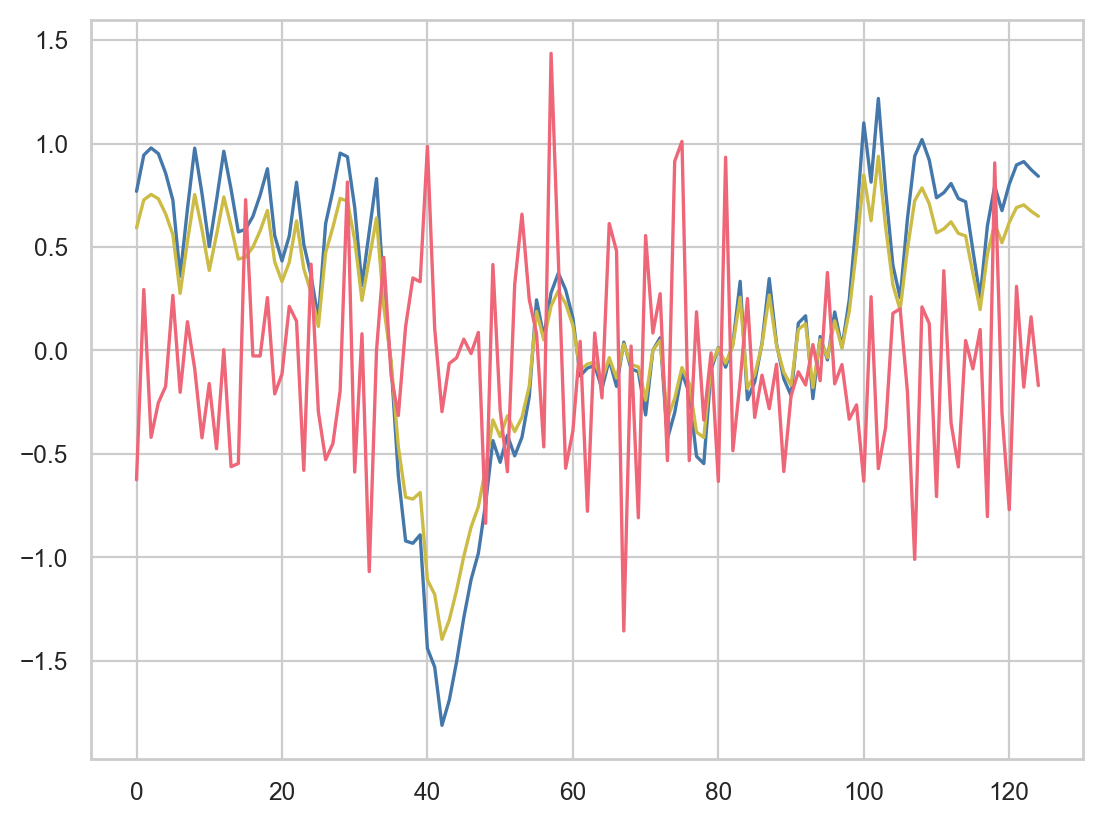

In [15]:
sigma = 0.5
beta = 2 # the exponent for red noise
samples = xclean.shape[1] # number of samples to generate
rng = np.random.default_rng(1)
y = cn.powerlaw_psd_gaussian(beta, samples, random_state=rng) 
plt.plot(y)
plt.plot(y * sigma / y.std())
plt.plot(sigma * rng.standard_normal(xclean.shape[1]))

In [16]:
xdata_wn = (
    xclean
    + sigma * rng.standard_normal(xclean.shape)
    + 1j * sigma * rng.standard_normal(xclean.shape)
)


Text(0.5, 1.0, 'White Noise for Toy Data')

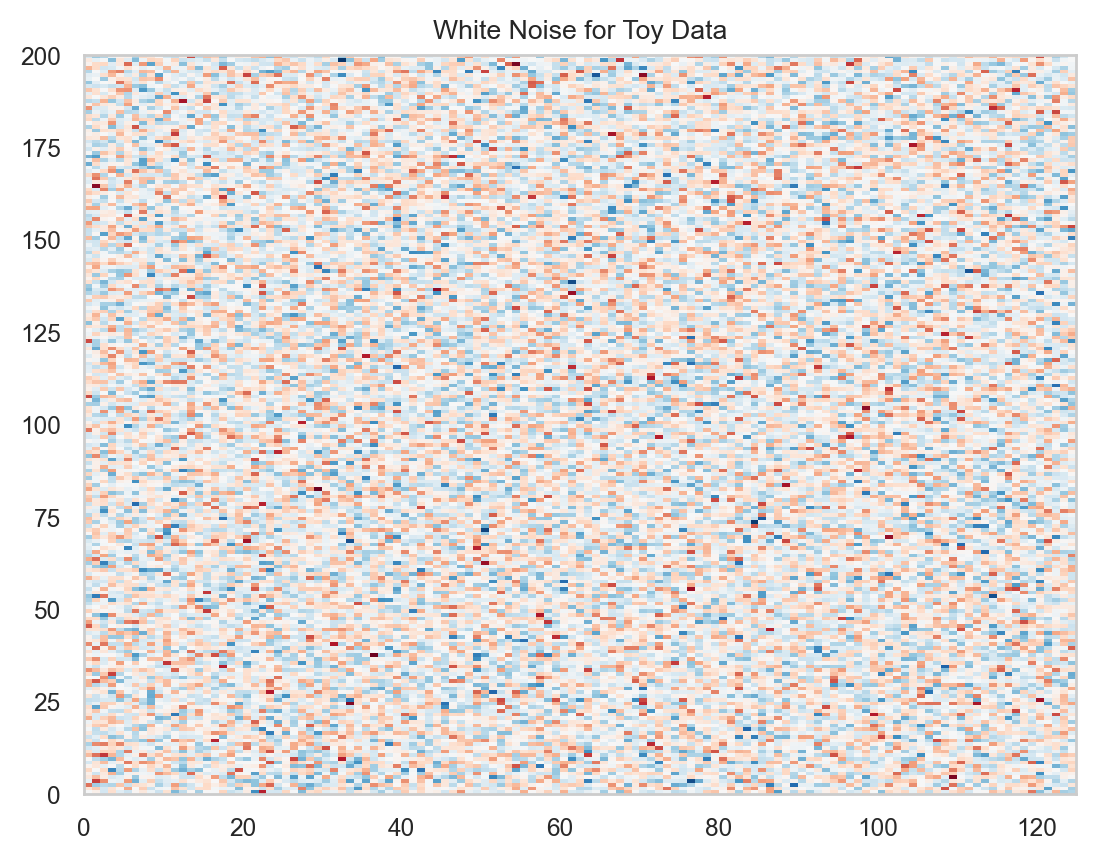

In [17]:
plt.pcolormesh(np.real(xdata_wn - xclean), vmin=-2, vmax=2, cmap='RdBu_r')
plt.gca().set_title('White Noise for Toy Data')

In [18]:
rng = np.random.default_rng(1)
rn_r = np.array([cn.powerlaw_psd_gaussian(beta, samples, random_state=rng) for _, _ in enumerate(xspace)])
rn_i = np.array([cn.powerlaw_psd_gaussian(beta, samples, random_state=rng) for _, _ in enumerate(xspace)])

rn_sigma_scaling = np.mean([sigma / rn_r.std(), sigma / rn_i.std()])
xdata_rn = (
    xclean
    + rn_sigma_scaling * rn_r
    + 1j * rn_sigma_scaling * rn_i
)


Text(0.5, 1.0, 'Red Noise for Toy Data')

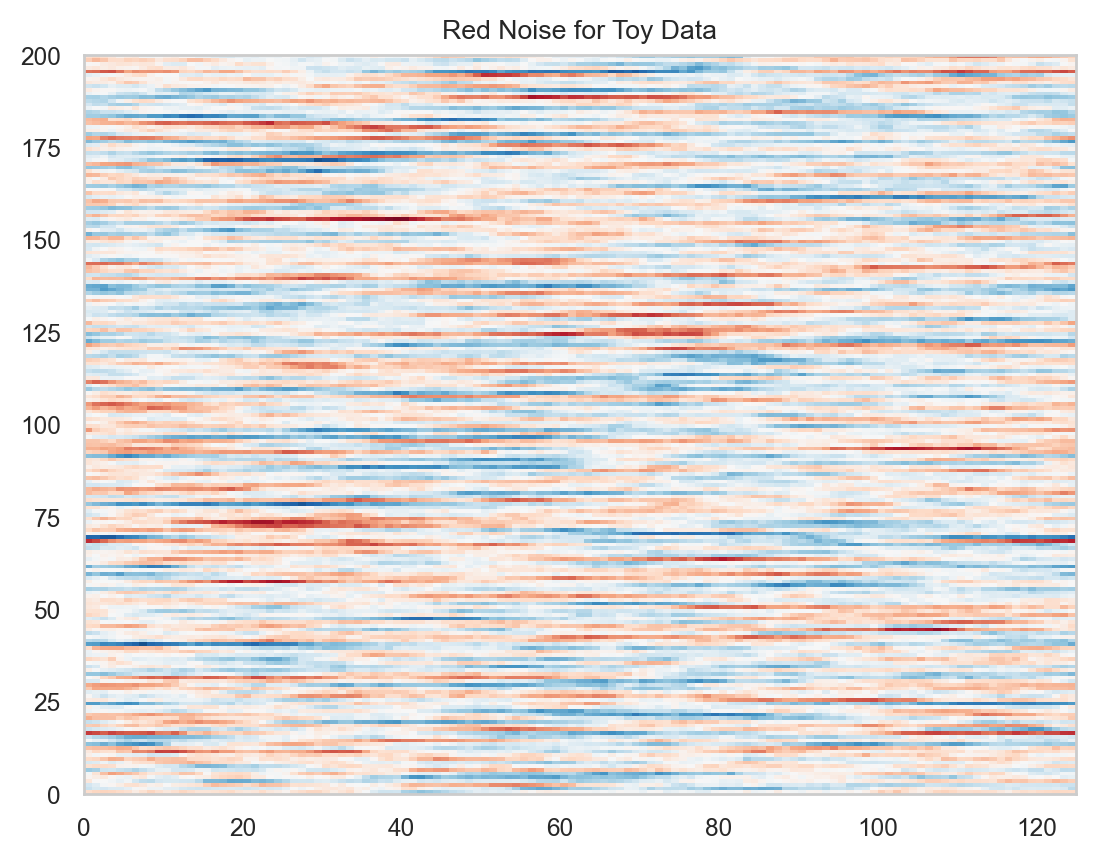

In [19]:
plt.pcolormesh(np.real(xdata_rn - xclean), vmin=-2, vmax=2, cmap='RdBu_r')
plt.gca().set_title('Red Noise for Toy Data')

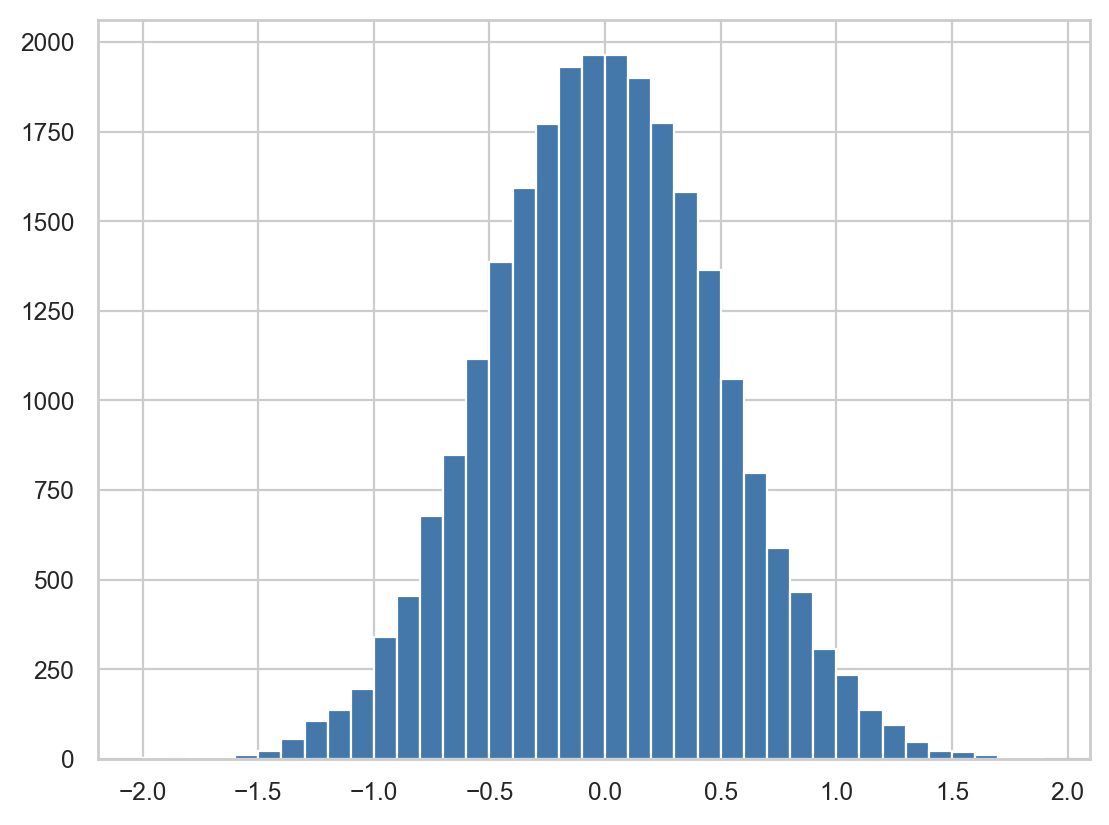

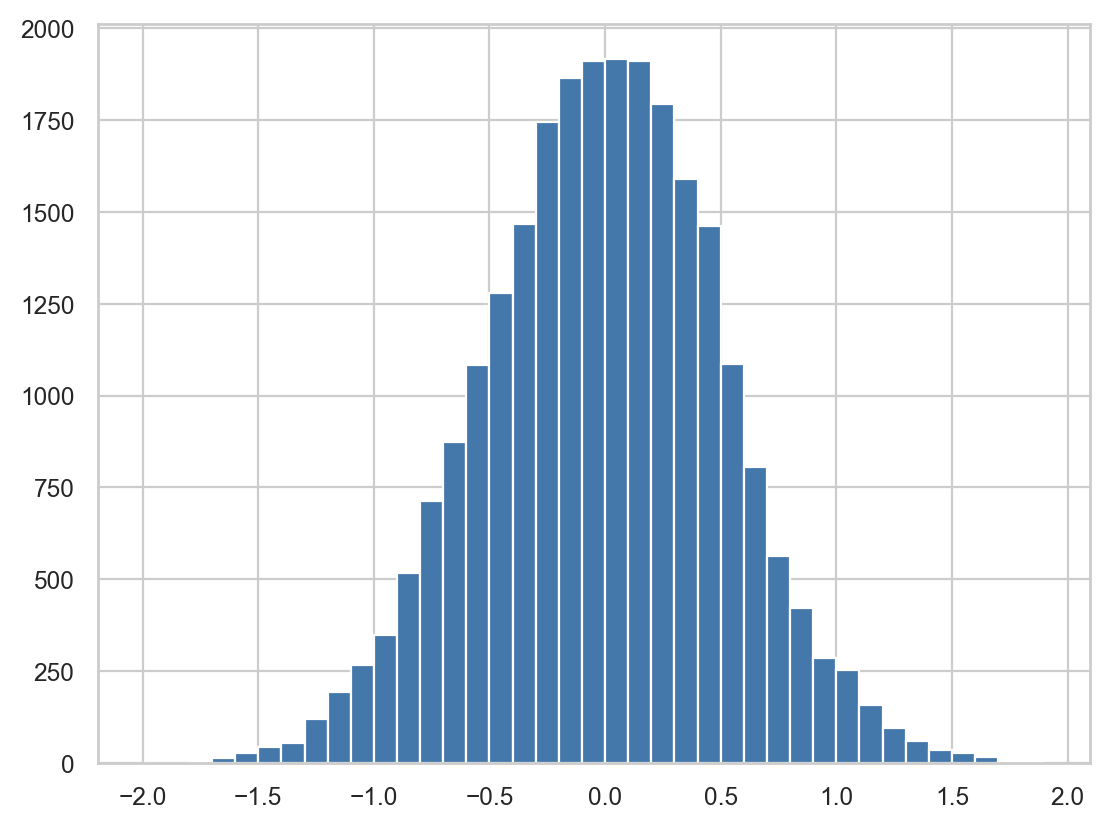

In [20]:
plt.hist(np.real(xdata_wn - xclean).flatten(), bins=np.arange(-2, 2, 0.1));

plt.figure()
plt.hist(np.real(xdata_rn - xclean).flatten(), bins=np.arange(-2, 2, 0.1));

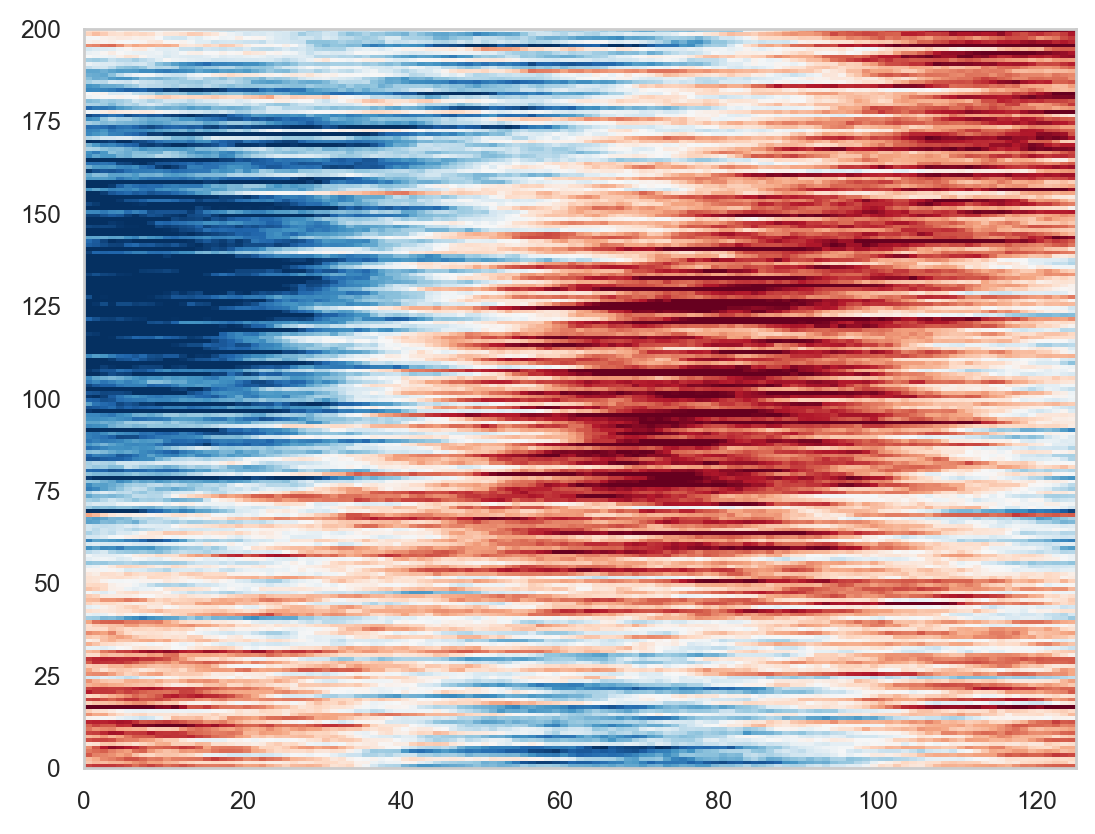

In [21]:
plt.pcolormesh(np.real(xdata_rn), vmin=-2, vmax=2, cmap='RdBu_r')


# from scipy.ndimage import gaussian_filter

# plt.figure()
# result = gaussian_filter(xdata_rn, sigma=2)
# plt.pcolormesh(np.real(result), vmin=-2, vmax=2, cmap='RdBu_r')

# Generate Data

In [22]:
# Generate the synthetic data.

# Set up modes in space.
x0 = 0
x1 = 2 * np.pi
nx = 200

# Space component is evenly spaced.
xspace = np.linspace(x0,x1,nx)

# Set up the spatial modes
f1 = np.sin(xspace)[:, np.newaxis]
f2 = np.cos(xspace)[:, np.newaxis]
f3 = np.tanh(xspace)[:, np.newaxis]

# Set up the time dimension.
t0 = 0
t1 = 0.25
t2 = t1 + t1 * 0.1
t_extended = int(t1 * 10)
num_timesteps_per_1s = 500
nt = int(num_timesteps_per_1s * t1)

ts = np.linspace(t0, t1, nt, endpoint=False)[np.newaxis, :]
ts_forecast = np.linspace(t1, t2, nt // 10, endpoint=False)[np.newaxis, :]
ts_extended = np.linspace(t0, t_extended, t_extended * num_timesteps_per_1s, endpoint=False)[np.newaxis, :]

# Temporal eigenvalues for each mode
e1 = -2.5 + 10j
e2 = 0 + 23j
e3 = 0 - 13j
true_eigenvalues = np.array([e1, e2, e3])
# Phase offset of the temporal modes
phase = [0, 0, -np.pi]

# Generate the clean, noiseless dynamics.
xclean = simple_example([f1, f2, f3], true_eigenvalues, ts, phase)
xclean_extended = simple_example([f1, f2, f3], true_eigenvalues, ts_extended, phase)
xclean_forecast = simple_example([f1, f2, f3], true_eigenvalues, ts_forecast, phase)

## Common Parameters

In [23]:
# Number of time points
n = len(ts)

# Number of noisy realizations to generate.
num_noise_cycles = 10
# Number of ensemble members for each noise realization.
num_ensembles =  50
# Number of points to select for each ensemble.
p = 0.3
ensemble_size = int(num_ensembles * p)

# Select a much larger noise level than in the paper to better illustrate
# improved ensemble selection strategies.
# sigma_array = [1e-1, 1e-2, 1e-3]
sigma_array = [5e-1, 1e-1]

verbose = False

# Test various strategies for improving the BOP-DMD fit

## Fitting without any improvement strategies

### Red Noise: Fit and Evaluate

In [24]:
ds_optdmd, ds_bopdmd, optdmd_container, bopdmd_container = run_noisy_realizations(
    xclean, ts, sigma_array, num_noise_cycles, num_ensembles, ensemble_size, true_eigenvalues, seed=1, red_noise=True)

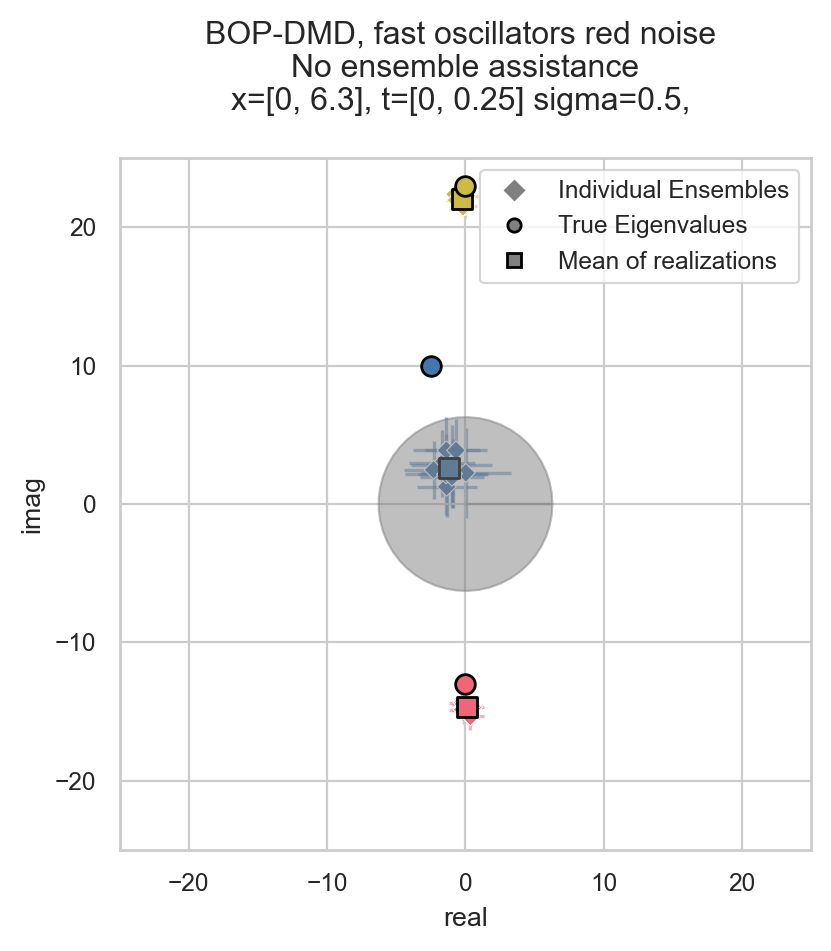

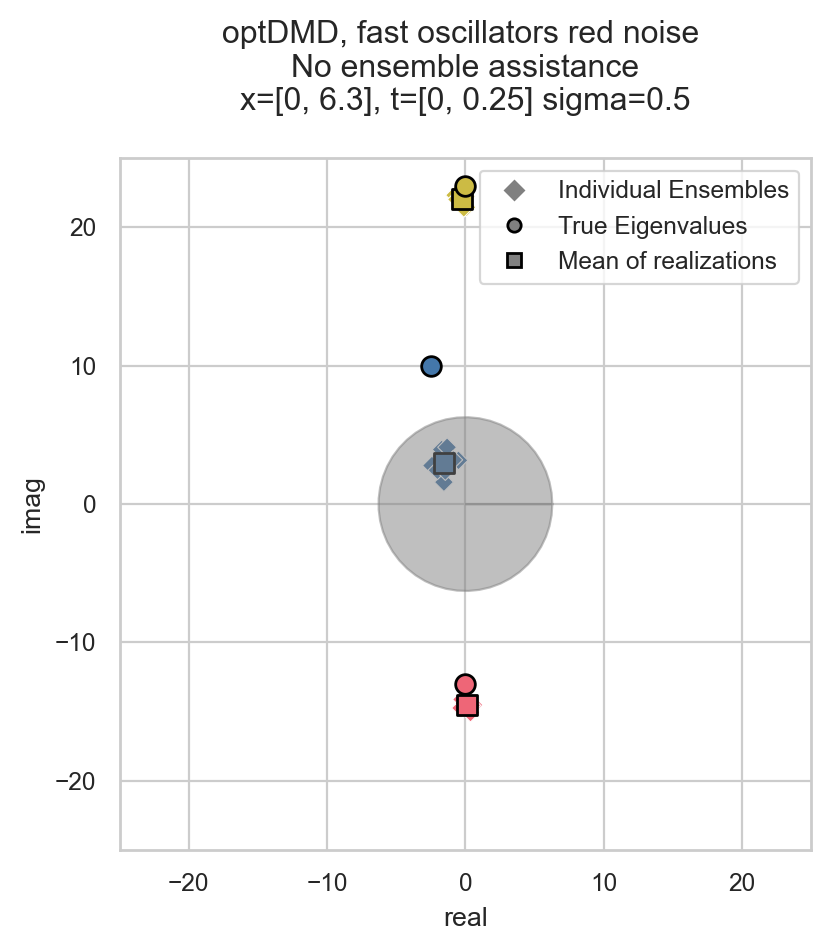

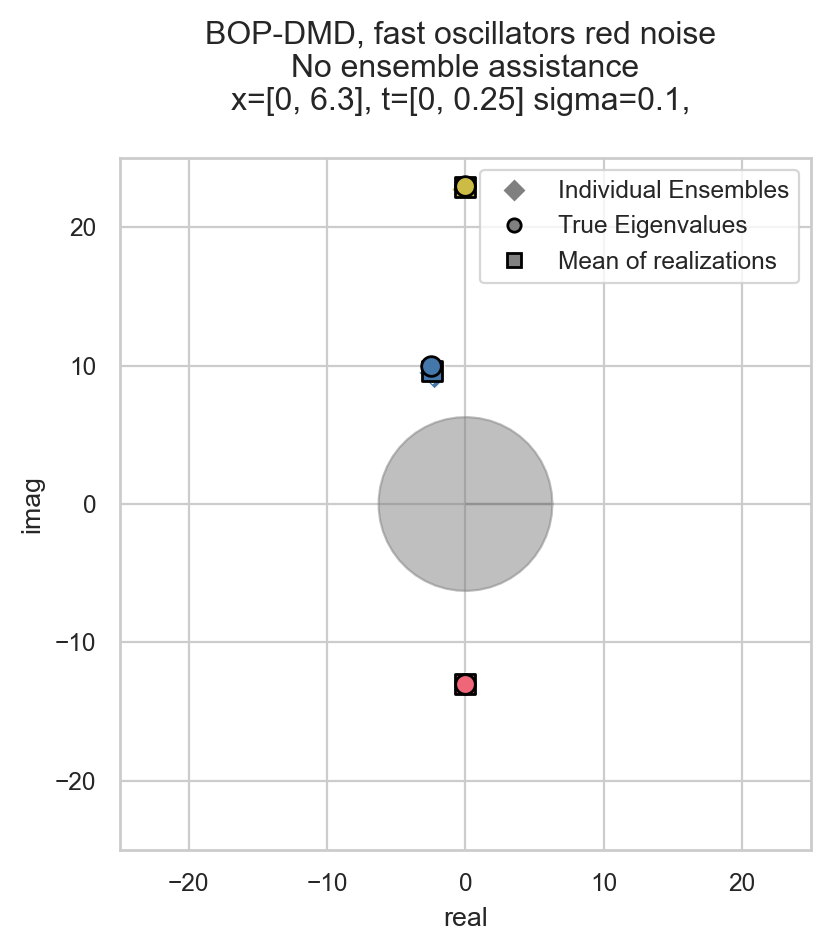

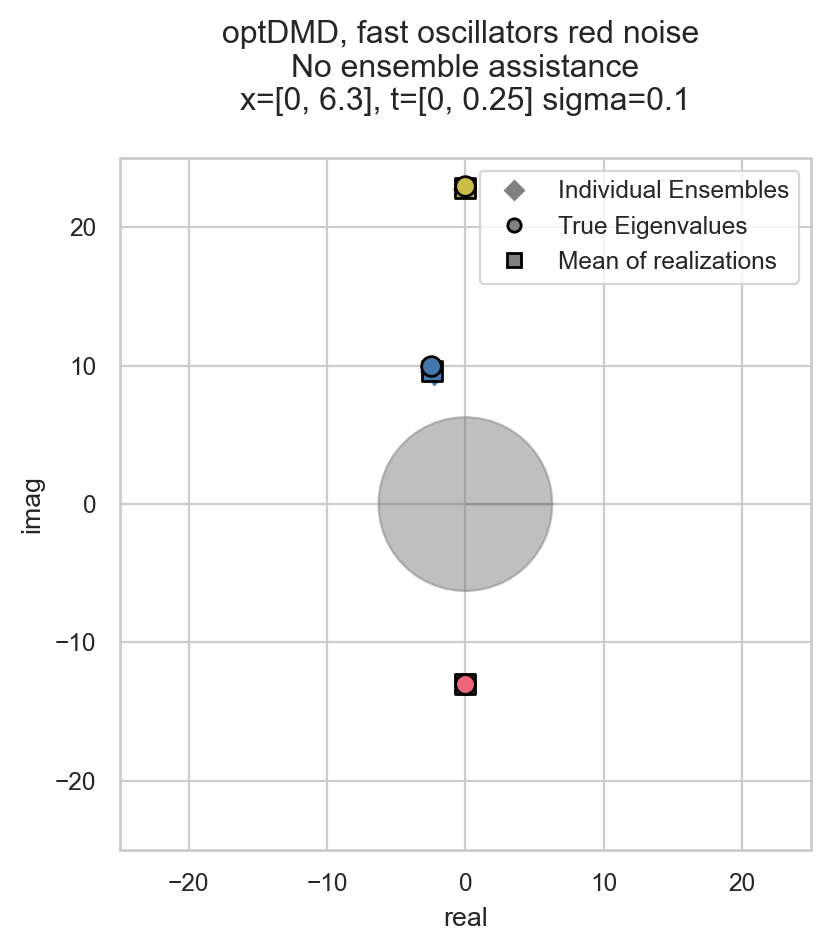

In [29]:
radii = [0, np.pi / (2 * t1)]
xs, ys = certainty_donut(radii)

# Distribution plots for the BOP-DMD and optDMD eigenvalues.
for s in ds_bopdmd.sigma:
    plt.figure()
    g = eigenvalue_scatterplot(ds_bopdmd.sel(sigma=s), true_eigenvalues, lims=(-25, 25))
    plt.gcf().suptitle(
        "BOP-DMD, fast oscillators red noise \nNo ensemble assistance\nx=[0, {:1.2}], t=[0, {:1.2f}], sigma={}, ".format(x1, t1, s.values))
    plt.gcf().tight_layout()
    # g.fill(np.ravel(xs), np.ravel(ys), edgecolor='k', color='0.5', alpha=0.5)
    g.fill(xs, ys, edgecolor='k', color='0.5', alpha=0.5)

    plt.figure()
    g = eigenvalue_scatterplot(ds_optdmd.sel(sigma=s), true_eigenvalues, lims=(-25, 25))
    plt.gcf().suptitle(
        "optDMD, fast oscillators red noise \nNo ensemble assistance\nx=[0, {:1.2}], t=[0, {:1.2f}], sigma={}".format(x1, t1, s.values))
    plt.gcf().tight_layout()
    # g.fill(np.ravel(xs), np.ravel(ys), edgecolor='k', color='0.5', alpha=0.5)
    g.fill(xs, ys, edgecolor='k', color='0.5', alpha=0.5)


### White Noise: Fit and Evaluate

In [30]:
ds_optdmd, ds_bopdmd, optdmd_container, bopdmd_container = run_noisy_realizations(
    xclean, ts, sigma_array, num_noise_cycles, num_ensembles, ensemble_size, true_eigenvalues, seed=1, red_noise=False)

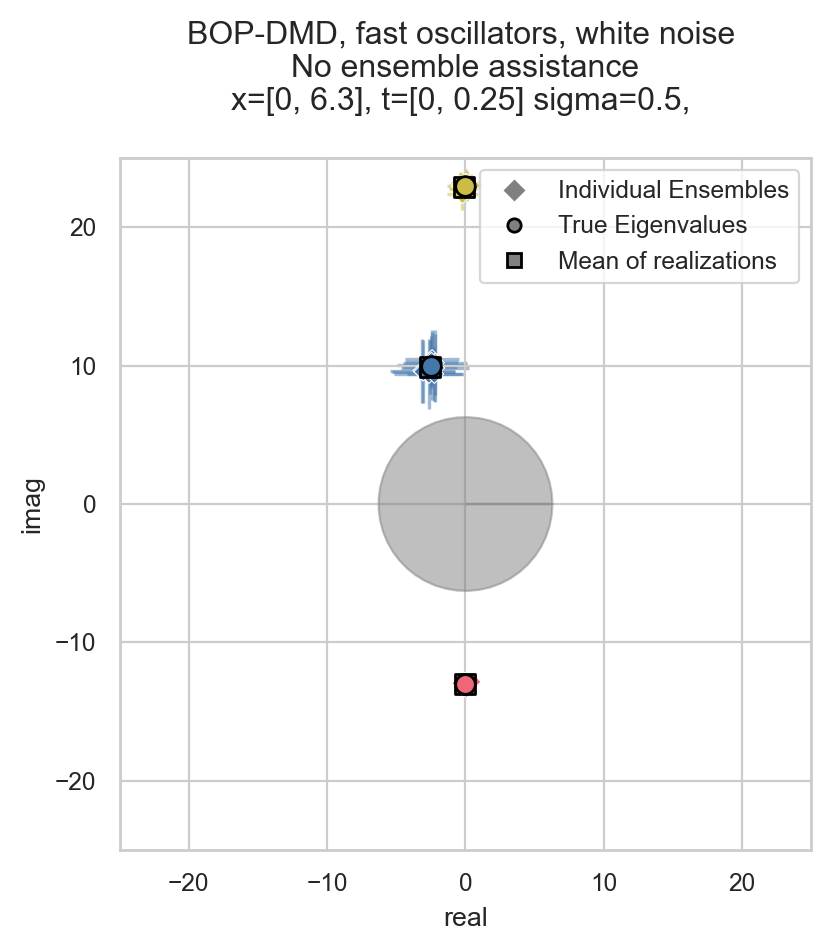

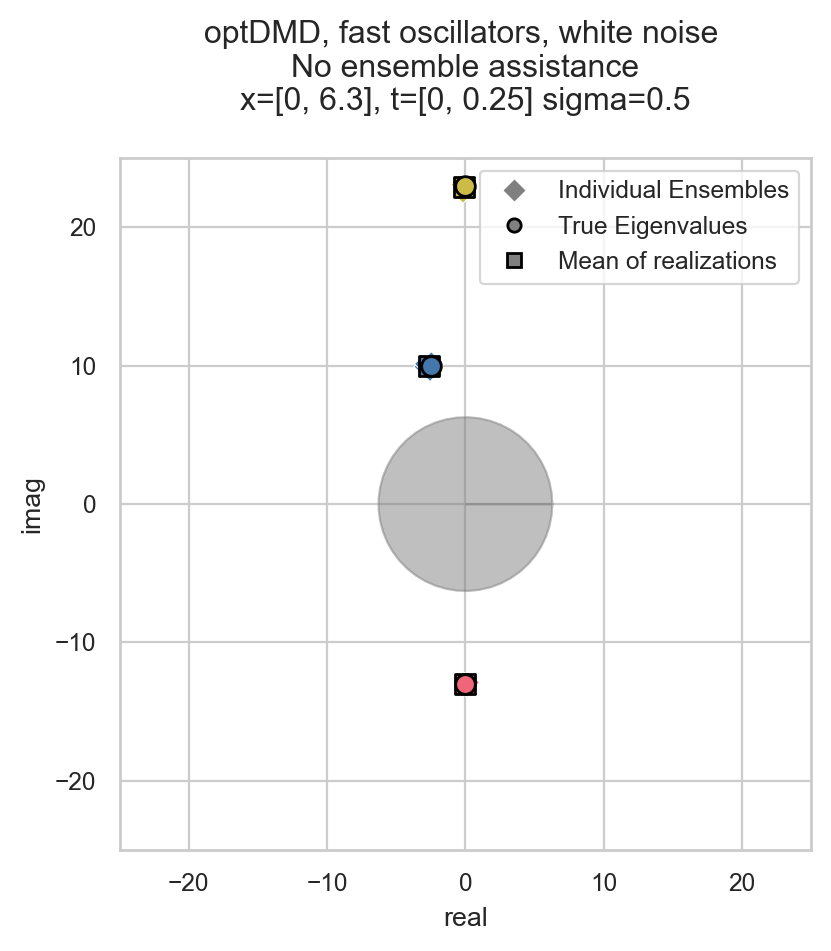

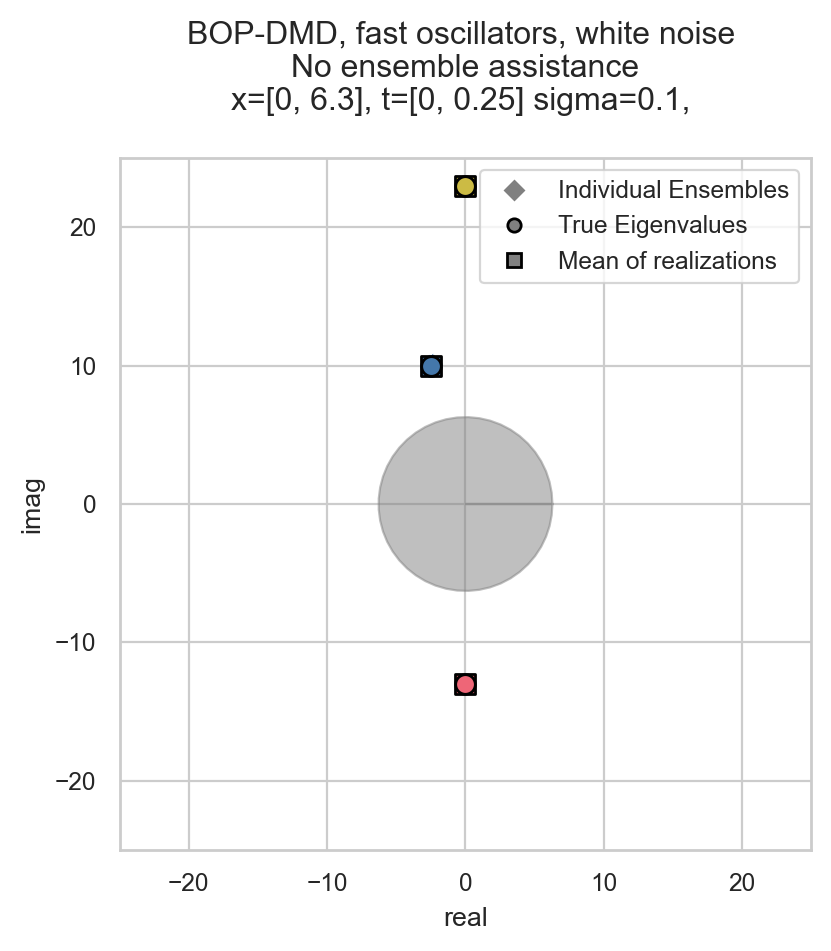

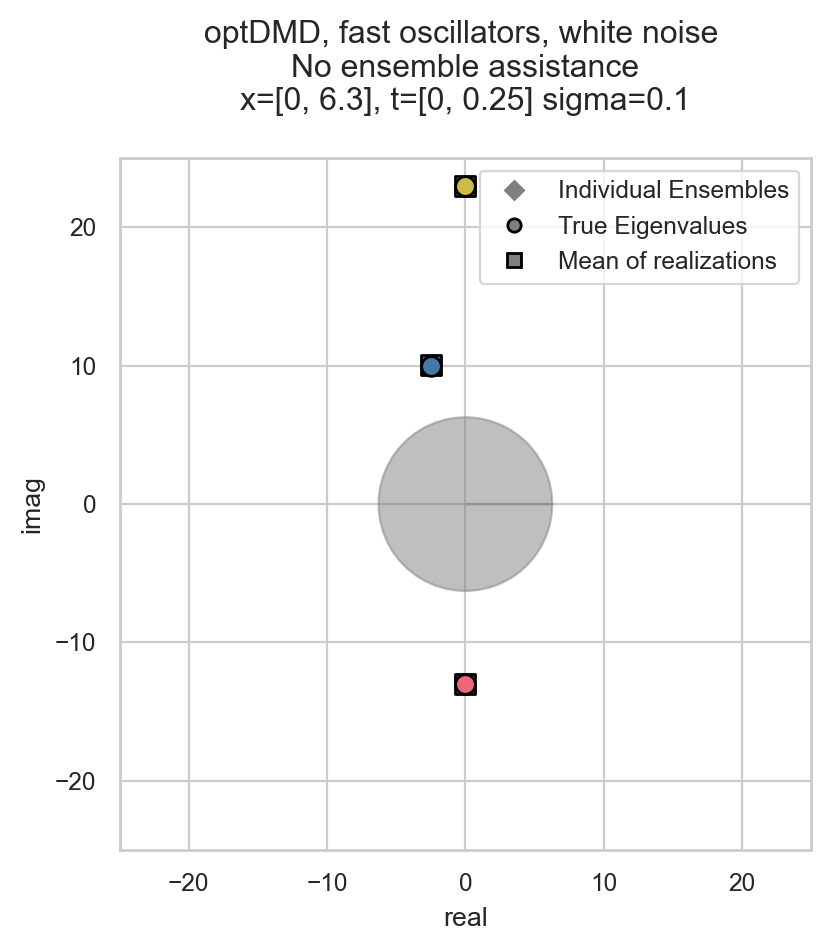

In [31]:
# Distribution plots for the BOP-DMD and optDMD eigenvalues.
for sigma in ds_bopdmd.sigma:
    plt.figure()
    g = eigenvalue_scatterplot(ds_bopdmd.sel(sigma=sigma), true_eigenvalues, lims=(-25, 25))
    plt.gcf().suptitle(
        "BOP-DMD, fast oscillators, white noise \nNo ensemble assistance\nx=[0, {:1.2}], t=[0, {:1.2f}] sigma={}, ".format(x1, t1, sigma.values))
    plt.gcf().tight_layout()
    g.fill(np.ravel(xs), np.ravel(ys), edgecolor='k', color='0.5', alpha=0.5)

    plt.figure()
    g = eigenvalue_scatterplot(ds_optdmd.sel(sigma=sigma), true_eigenvalues, lims=(-25, 25))
    plt.gcf().suptitle(
        "optDMD, fast oscillators, white noise \nNo ensemble assistance\nx=[0, {:1.2}], t=[0, {:1.2f}] sigma={}".format(x1, t1, sigma.values))
    plt.gcf().tight_layout()
    g.fill(np.ravel(xs), np.ravel(ys), edgecolor='k', color='0.5', alpha=0.5)

## Including a long-term prior in the fit

### Establish weakly-informative priors

Next is to determine the long-term behavior for providing the priors. In a real application we would use expert knowledge (e.g., climatology for weather or oceanographic data).

To mimic this behavior in the toy system, we take block averages at a coarser time step than the original time domain used to fit the dmds (e.g., t_block = 30 * dt where dt=0.01, yielding blocks .3 in width).

For our "long term" data set this means 50 blocks (t2 = 15 with blocks of 0.3 width = 15 // 0.3 = 50).

The mean over the last dimension gives the mean of that time block.



In [32]:
lt_length = 10
dt = int(nt)
block_subdivision = 5
num_block_time_offset = 20
block_size = dt // block_subdivision
offset = num_block_time_offset * block_size

# Give weakly informative priors for the long-term mean.
lt_mean = np.zeros((nx, lt_length))
# lt_climatology = np.atleast_2d(xclean_extended[:, slice(-lt_length * dt, None, dt)])

# Keep the space dimension, create a new dimension for the block, and make each block the appropriate width
lt_climatology = xclean_extended.reshape((xclean_extended.shape[0], -1, block_size)).mean(axis=-1)[:, block_subdivision + num_block_time_offset:]

# Set this long term mean to be far in the future.
# ts_lt = np.array([np.arange(t1 * 10, t1 * 10 + lt_length)])
# ts_lt = np.atleast_2d(ts_extended[:, slice(-lt_length * dt, None, dt)])
ts_lt = ts_extended[:, int(nt + dt // (block_subdivision * 2)) + offset::int(block_size)]

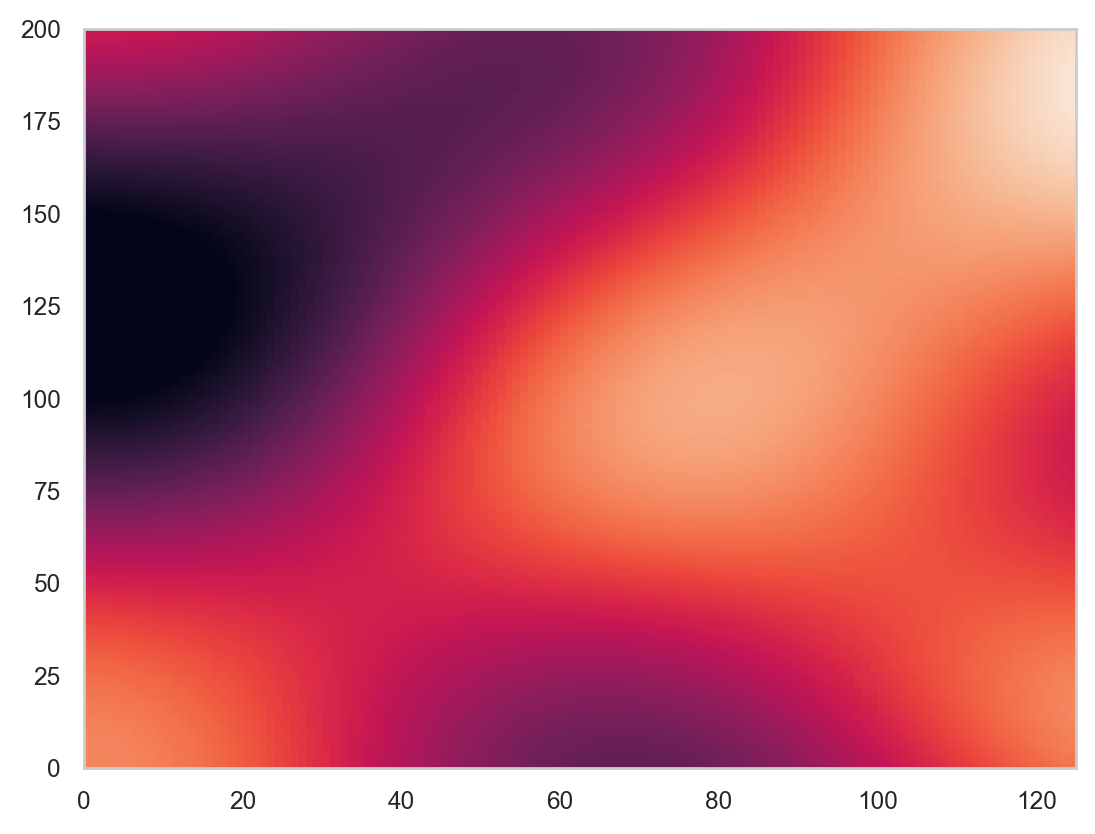

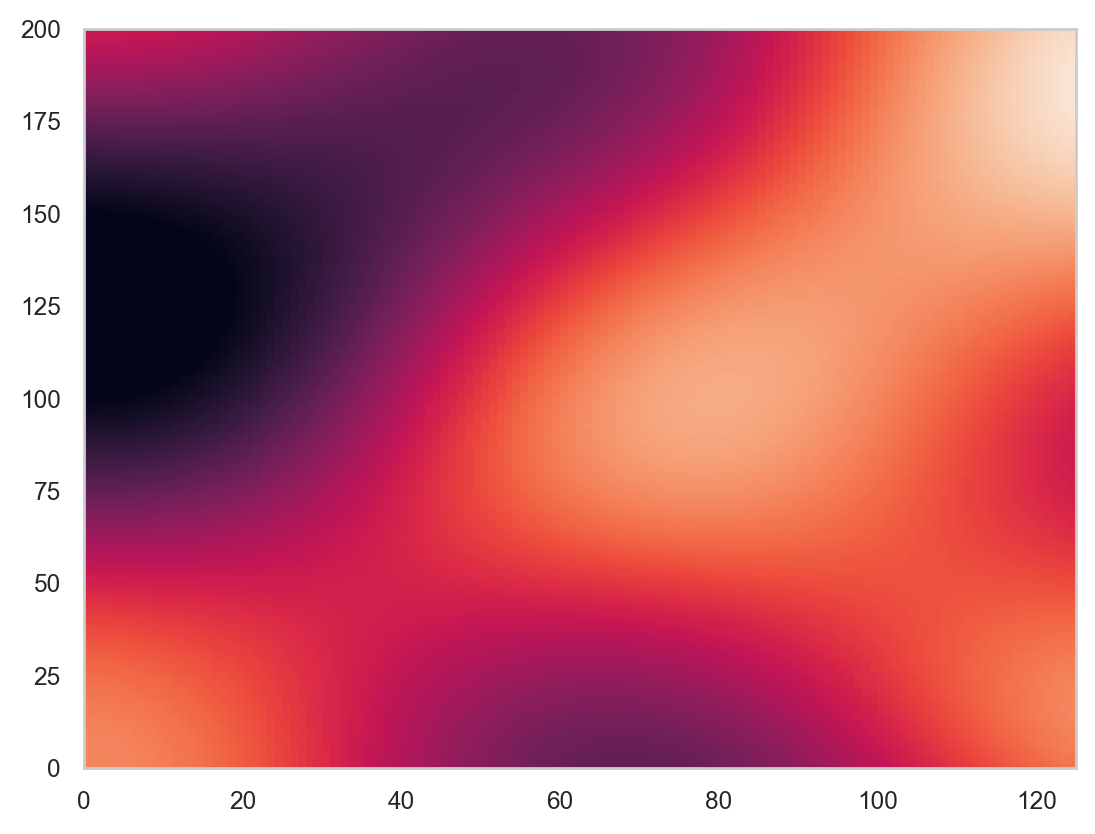

In [33]:
# This resahpe behavior can be quickly verified by settting the dt to the original dt and comparing to xclean
plt.pcolormesh(np.real(xclean), vmin=-2, vmax=2)

plt.figure()
plt.pcolormesh(np.real(xclean_extended.reshape((xclean_extended.shape[0], -1, dt))[:, 0, :]), vmin=-2, vmax=2)

And then we can compare the time mean for equivalent time blocks between xclean and the resahped long term data.

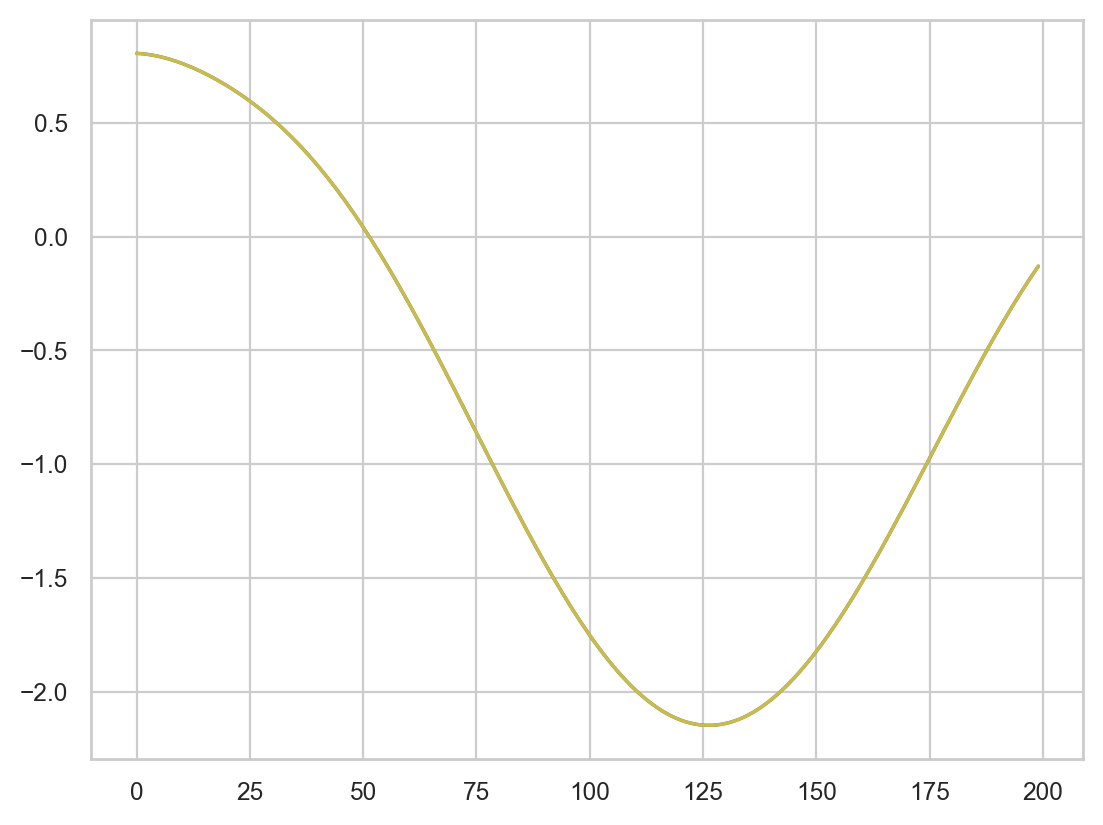

In [34]:
plt.plot(xclean_extended.reshape((xclean_extended.shape[0], -1, block_size)).mean(axis=-1)[:, 0])
plt.plot(xclean[:, 0:block_size].mean(axis=1))

Using the climatology for the entire period creates too tight of a fit (no uncertainty in the eigenvalues)

Two strategies for making this more realistic and not overly constraining a toy system:

- Don't use the entire period of climatology, put it some time into the future
- Corrupt the climatology with some noise

Text(0.5, 1.0, 'Data with climatological priors')

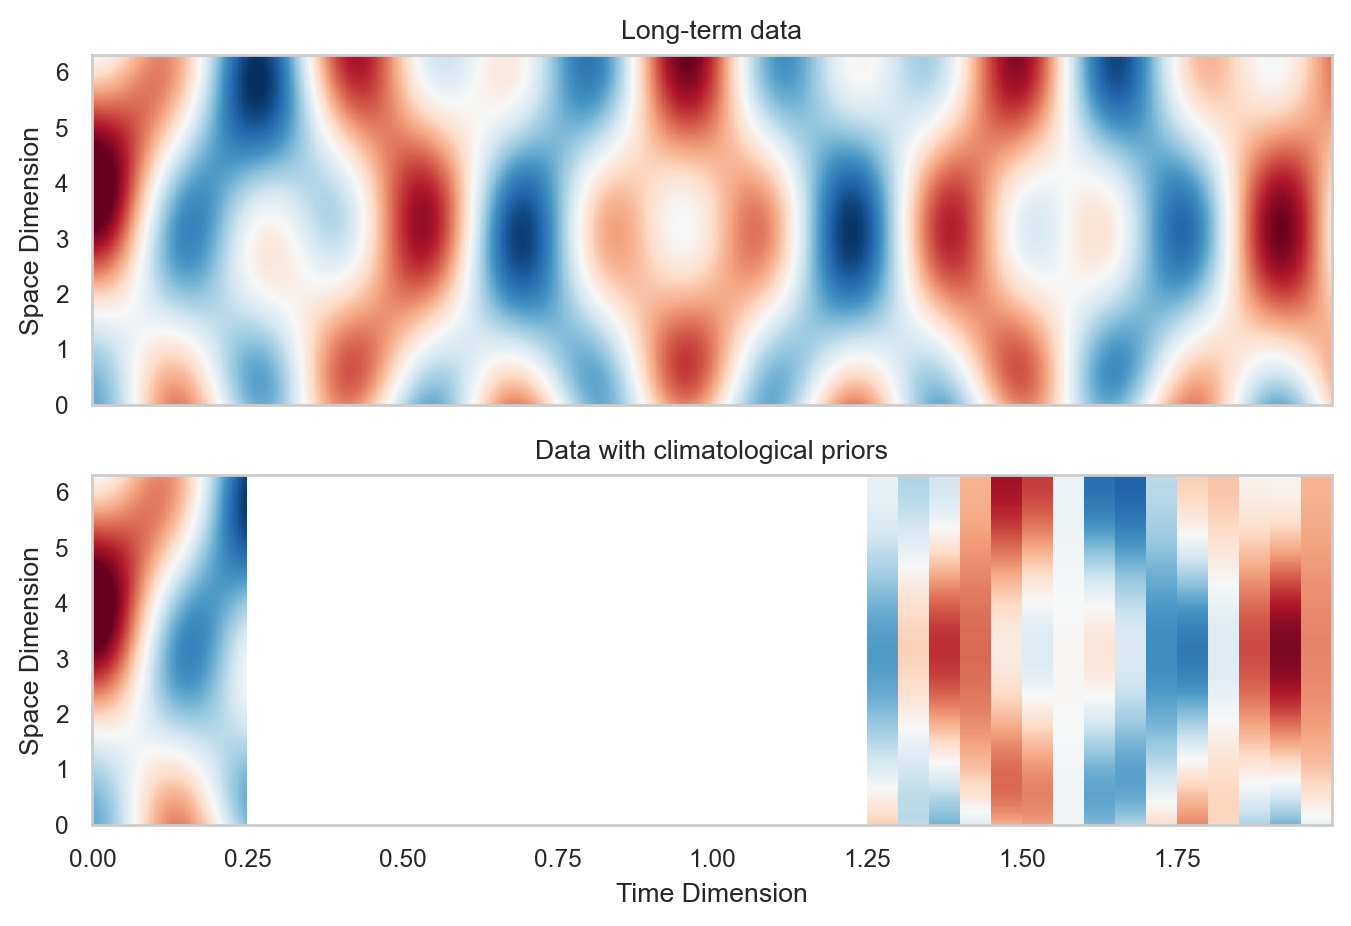

In [35]:
fig, axes = plt.subplots(2, 1, figsize=(8, 5), sharex=True)

ax = axes[0]
c = ax.pcolormesh(ts_extended, xspace, np.real(xclean_extended), vmin=-2, vmax=2, cmap='RdBu')
# fig.colorbar(c)
ax.set_title('Long-term data')
ax.set_ylabel('Space Dimension')

ax = axes[1]
ax.pcolormesh(ts_lt, xspace, np.real(lt_climatology), vmin=-2, vmax=2, cmap='RdBu')
ax.pcolormesh(ts, xspace, np.real(xclean), vmin=-2, vmax=2, cmap='RdBu')
ax.set_xlabel('Time Dimension')
ax.set_ylabel('Space Dimension')
ax.set_title('Data with climatological priors')


### Fit + Climatology + White Noise

In [40]:
(ds_optdmd, ds_bopdmd, optdmd_container, bopdmd_container) = run_noisy_realizations(
    xclean, ts, sigma_array, num_noise_cycles, num_ensembles, ensemble_size,
    true_eigenvalues, seed=1, ts_longterm=ts_lt, data_longterm=lt_climatology,
    red_noise=False
)


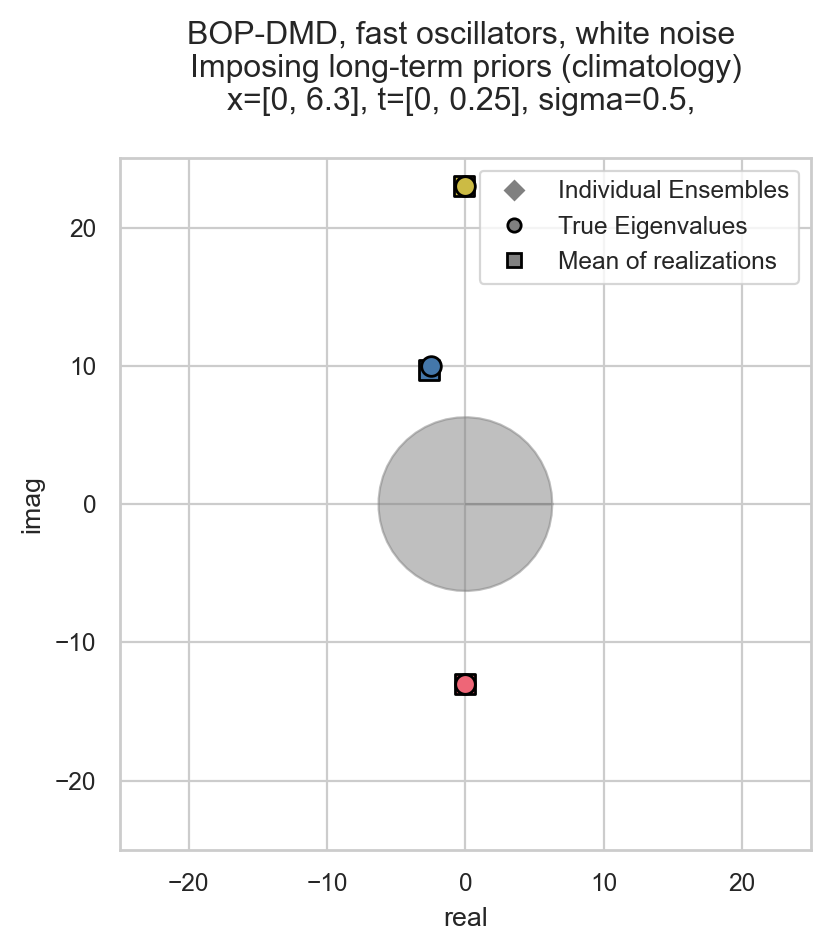

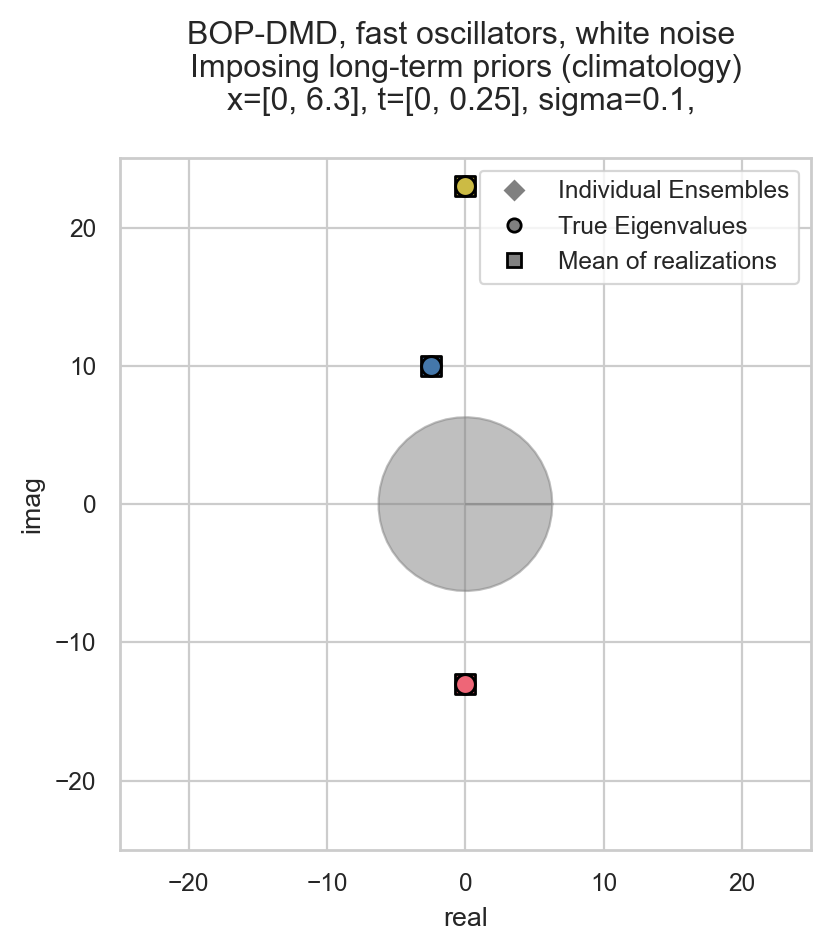

In [44]:
# Distribution plots for the BOP-DMD and optDMD eigenvalues.
for sigma in ds_bopdmd.sigma:
    plt.figure()
    g = eigenvalue_scatterplot(ds_bopdmd.sel(sigma=sigma), true_eigenvalues, lims=(-25, 25))
    plt.gcf().suptitle(
        "BOP-DMD, fast oscillators, white noise \nImposing long-term priors (climatology)\nx=[0, {:1.2}], t=[0, {:1.2f}], sigma={}, ".format(x1, t1, sigma.values))
    plt.gcf().tight_layout()
    g.fill(np.ravel(xs), np.ravel(ys), edgecolor='k', color='0.5', alpha=0.5)

### Fit + Climatology + Red Noise

In [45]:
( ds_optdmd_climatology, ds_bopdmd_climatology, optdmd_container_climatology, bopdmd_container_climatology
) = run_noisy_realizations(
    xclean, ts, sigma_array, num_noise_cycles, num_ensembles, ensemble_size,
    true_eigenvalues, seed=1, ts_longterm=ts_lt, data_longterm=lt_climatology,
    red_noise=True
)


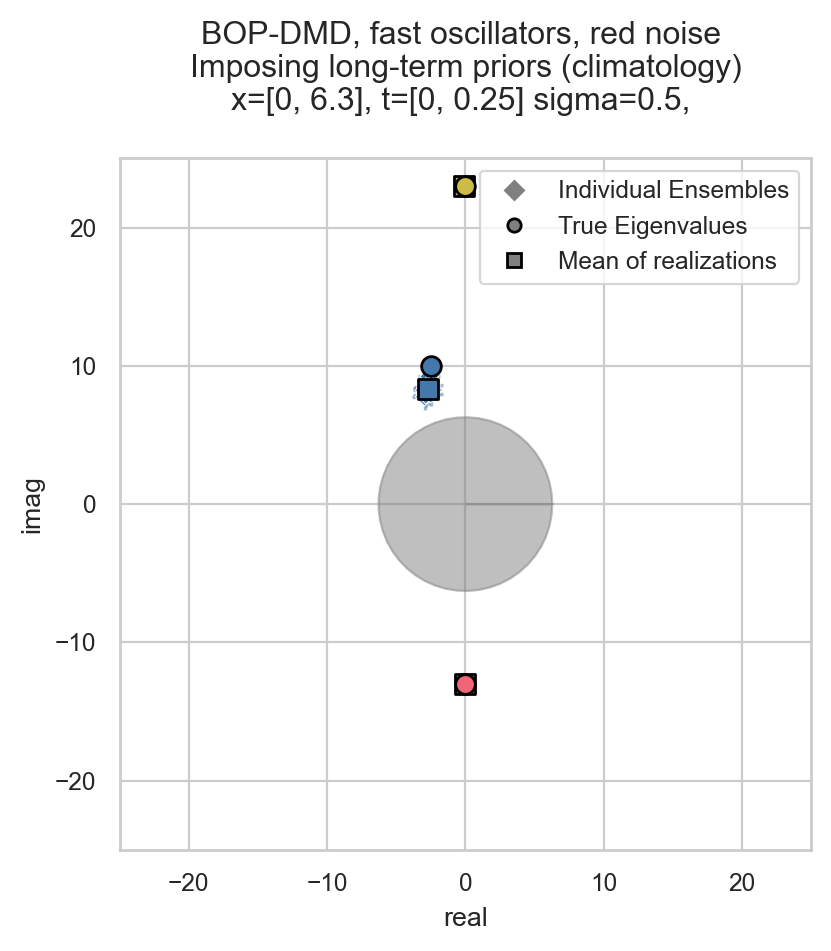

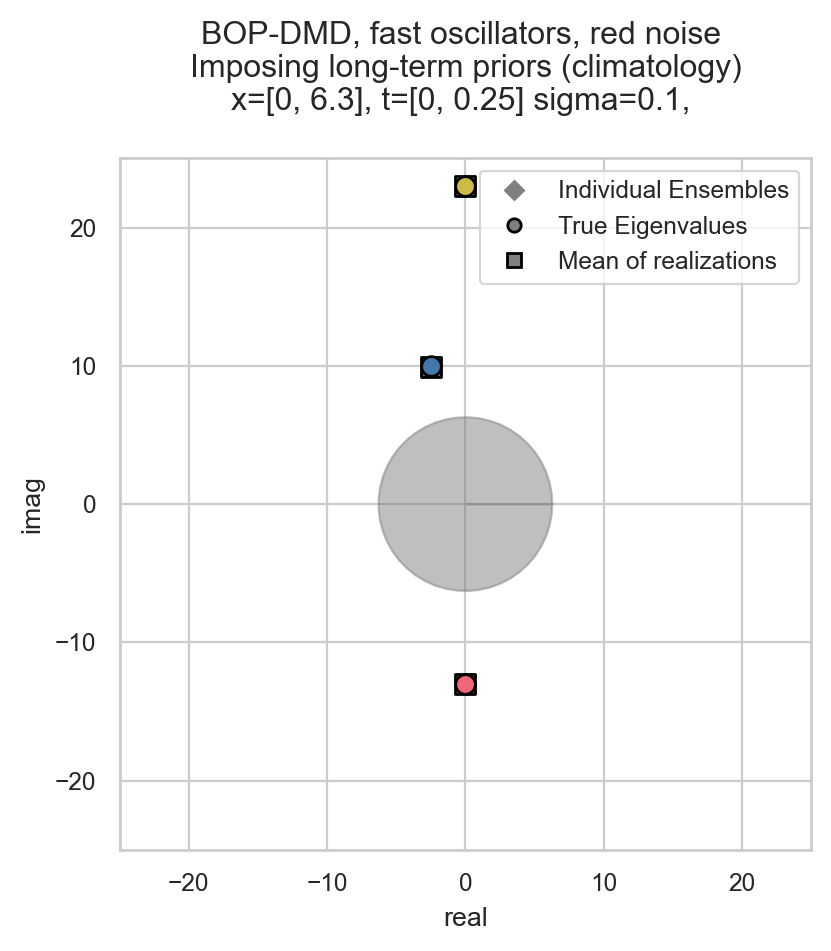

In [46]:
# Distribution plots for the BOP-DMD and optDMD eigenvalues.
for sigma in ds_bopdmd.sigma:
    plt.figure()
    g = eigenvalue_scatterplot(ds_bopdmd_climatology.sel(sigma=sigma), true_eigenvalues, lims=(-25, 25))
    plt.gcf().suptitle(
        "BOP-DMD, fast oscillators, red noise \nImposing long-term priors (climatology)\nx=[0, {:1.2}], t=[0, {:1.2f}] sigma={}, ".format(x1, t1, sigma.values))
    plt.gcf().tight_layout()
    g.fill(np.ravel(xs), np.ravel(ys), edgecolor='k', color='0.5', alpha=0.5)

Compare the eigenvalue spread against eigenvalue spread without climatology priors.

<AxesSubplot: xlabel='eigenvalue', ylabel='real_std'>

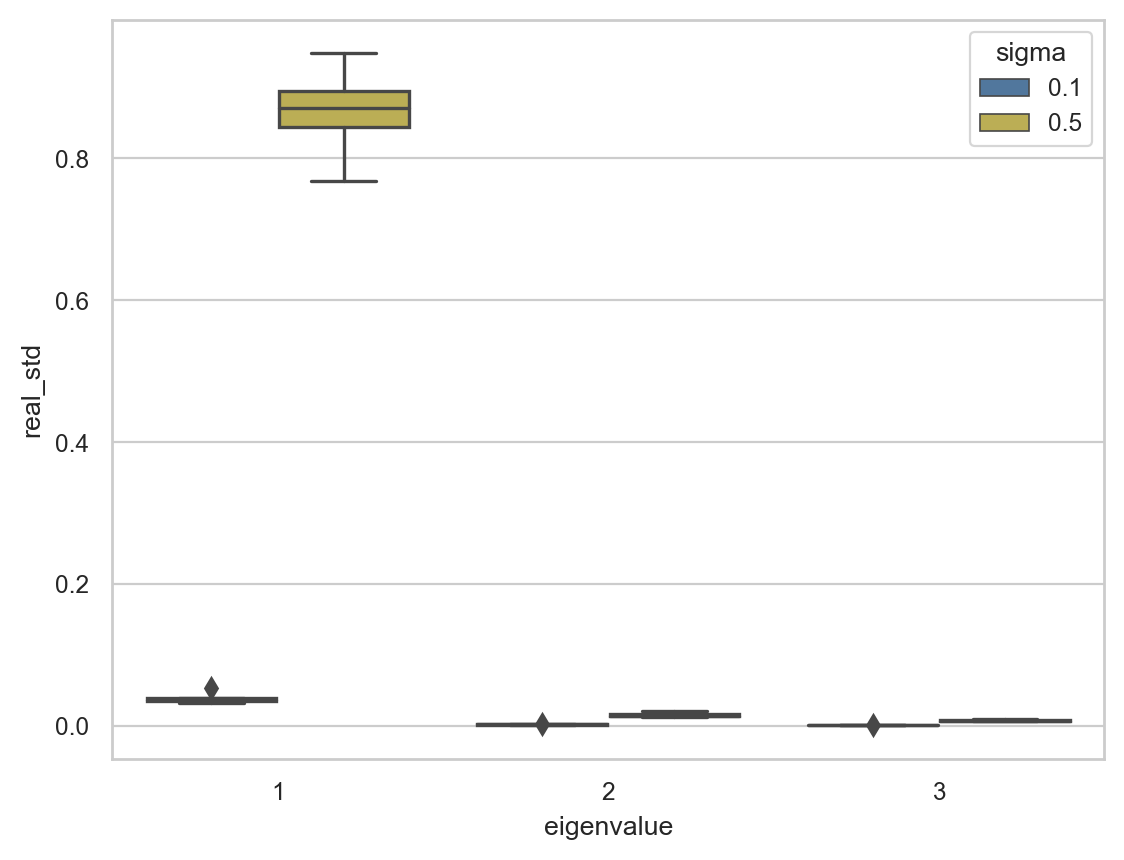

In [55]:
ds_bopdmd_climatology.drop(['noise realization'])
df = ds_bopdmd_climatology.real_std.to_dataframe().droplevel(1).reset_index()
sns.boxplot(data=df, x='eigenvalue', y='real_std', hue='sigma')

How does eigenvalue uncertainty compare to the error from the true eigenvalue? As in is the uncertainty a true measure of uncertainty. Visually, for red noise, it clearly is not since the BOP-DMD derived uncertainty doesn't quite line-up with the perceived uncertainty, e.g., error between mean eigenvalues and the true eigenvalues.

## Ensemble Pruning
- Discard ensemble members that have a poor evaluation against the forecast period.

In [56]:
r = 0
s = sigma_array[0]
n = 0
b = bopdmd_container_climatology[s][r][n]
o = optdmd_container_climatology[s][r]

(0.0, 0.25)

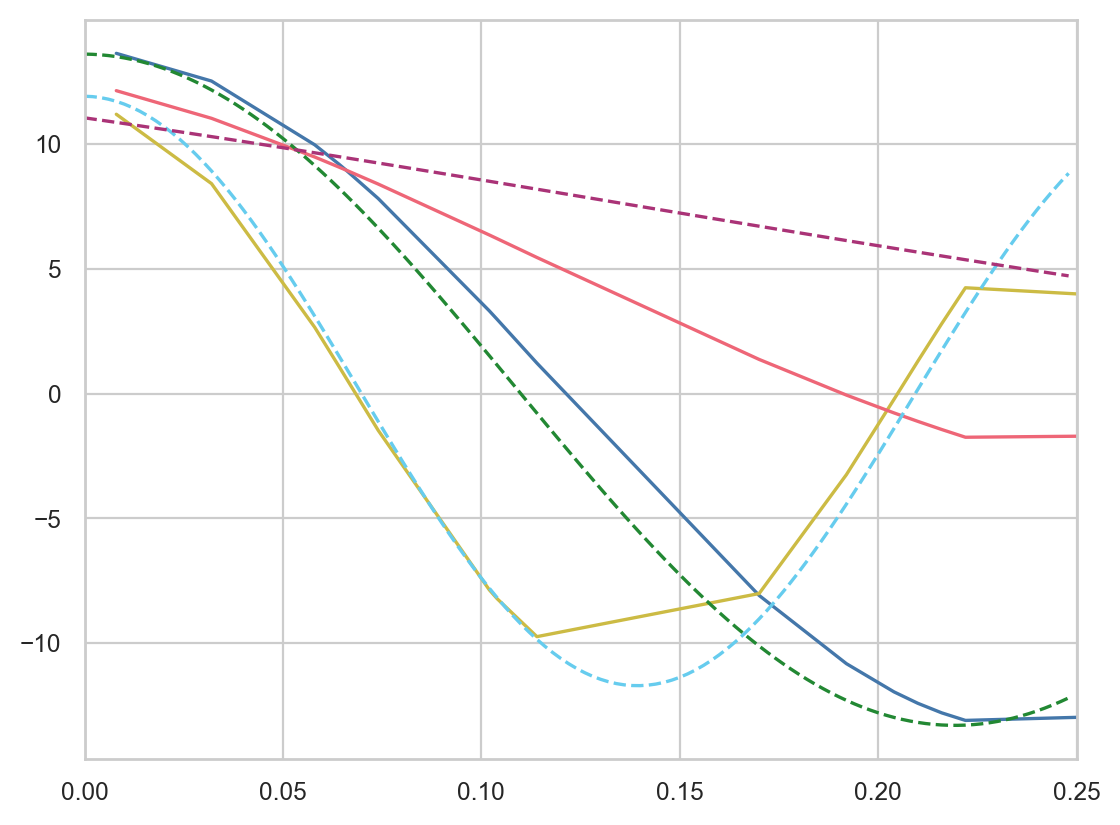

In [57]:
plt.plot(b.time, b.dynamics.T)
plt.plot(o.time, o.dynamics.T, ls='--')
plt.gca().set_xlim(t0, t1)

In [60]:
b.

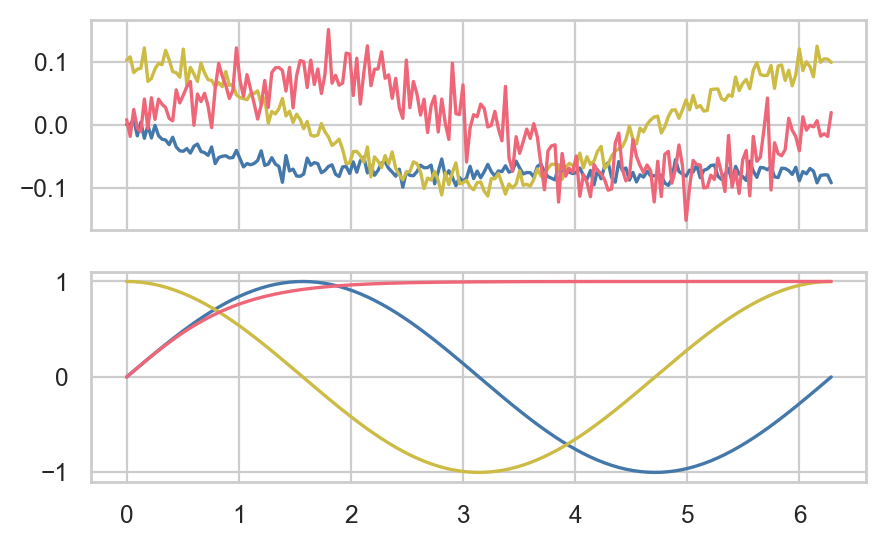

In [58]:
fig, axes = plt.subplots(2, 1, figsize=(5, 3), sharex=True)

ax = axes[0]
ax.plot(xspace, b.modes)

ax = axes[1]
ax.plot(xspace, f1)
ax.plot(xspace, f2)
ax.plot(xspace, f3)

Evaluate normalized error of eigenvalues

In [28]:
for n in range(num_ensembles):
    print(
        bopdmd_container[0.5][0][n].eigs
    )
ds = ds_bopdmd.sel(sigma=s).rename_dims({'noise realization': 'realization'})
real = ds.sel(realization=0).real.values
imag = ds.
    
    relerr_e = (
        np.linalg.norm(ds.sel(realization=0).values - true_eigs, 2)
        / np.linalg.norm(true_eigs, 2)
    )
    

[-0.18631305+2.2509131j  -0.25706862-0.45607176j -0.15117118-0.82537842j]


NameError: name 'e_mean_BOPDMD' is not defined

In [62]:
# for r in range(num_noise_cycles):
    # print(r)
r = 0
for n in range(num_ensembles):
    print(relative_error(
        xclean,
        bopdmd_container_climatology[.5][r][n].forecast(ts)
    ))
print()

0.32150724734465425
0.30672821845562404
0.3332605473901794
0.3011072988861159
0.3134784051197275
0.32408679556762193
0.3111152094174384
0.3145988260554031
0.30502724888683247
0.31586956128122196
0.31202492510208235
0.30505952459526287
0.30128909477739085
0.3019347957631971
0.3199517071889205
0.29853416435316843
0.3447392752152905
0.30629887381729454
0.2967870712922324
0.30819961652693784
0.30086392729036454
0.3161959211704528
0.28899180781827494
0.332268288339328
0.33793569256872247
0.3190301133839719
0.30033680166816923
0.3296132734733871
0.31896481571128305
0.3858735217028502
0.30316182951428
0.32159431904974095
0.3214870032898207
0.32046984516382954
0.32084223386501426
0.32387409628866465
0.3134935437363625
0.3133259582010337
0.33331654327756877
0.32443114476777435
0.306772253453394
0.31168413937441203
0.3071974143724562
0.3031442418965102
0.30635355773444756
0.3004561187890198
0.31390489776043484
0.32188108479860106
0.31543381059197173
0.2999444873485019



In [ ]:
for r in range(num_noise_cycles):
    print(r)
    for n in range(num_ensembles):
        print(relative_error(
            xclean_forecast,
            bopdmd_container[0.5][r][n].forecast(ts_forecast)
        ))
    print()

In [ ]:
print('Error in forecast:')
for n_ensemble in range(num_ensembles):
    x_predict = bop_dmd.predict(
        e_ensembleDMD[:, n_ensemble],
        w_ensembleDMD[:, :, n_ensemble],
        b_ensemble[:, n_ensemble],
        ts_forecast
    )
    relative_error_predict = relative_error(x_predict, xdata_forecast)
    print(relative_error_predict)

print('Error in reconstruction')
for n_ensemble in range(num_ensembles):
    x_reconstruct = bop_dmd.predict(
        e_ensembleDMD[:, n_ensemble],
        w_ensembleDMD[:, :, n_ensemble],
        b_ensemble[:, n_ensemble],
        ts
    )

    relative_error_reconstruct = relative_error(x_reconstruct, xdata)
    print(relative_error_reconstruct)

## Trial size by noise level

The BOP-DMD paper makes some statements on the optimal trial size that are likely not true given the non-ideal nature of the toy data set (see Figure 4 of Sashidar and Kutz, 2022). I rerun those tests here to get around that issue.

0.5
0.1
0.01


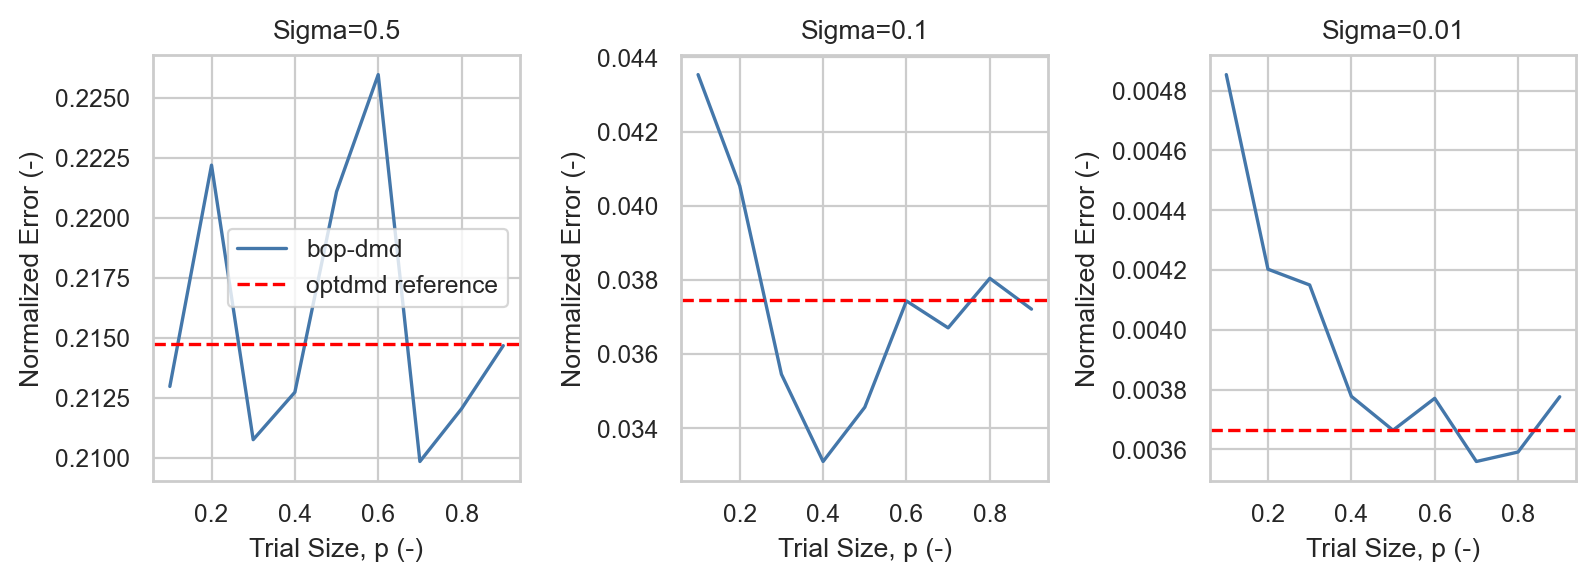

In [144]:
sigmas = [5e-1, 1e-1, 1e-2]
p_array = np.arange(10, 100, 10) / 100
number_ensembles = 100

fig, axes = plt.subplots(1, 3, figsize=(8, 3), sharex=True)

for ns, sigma in enumerate(sigmas):
    print(sigma)
    rng = np.random.default_rng(1)
    relerr_e = []
    xdata = (
        xclean
        + sigma * rng.standard_normal(xclean.shape)
        + 1j * sigma * rng.standard_normal(xclean.shape)
    )
    for p in p_array: 
        test_bopdmd = BOPDMD(
            svd_rank=3, trial_size=p, num_trials=number_ensembles)

        test_bopdmd.fit(xdata, ts)
        
        # Match the eigenvalues to the true ones using the Munkres algorithm.
        eigs = test_bopdmd.eigs
        _, indices = kl_bopdmd.match_vectors(eigs, true_eigenvalues)
        eigs = eigs[indices]
        
        relerr_e = np.append(relerr_e,
            np.linalg.norm(eigs - true_eigenvalues, 2)
            / np.linalg.norm(true_eigenvalues, 2)
        )
        
    ax = axes[ns]
    ax.plot(p_array, relerr_e, label='bop-dmd')
    
    # optdmd for comparison
    test_optdmd = BOPDMD(
        svd_rank=3, num_trials=0)
    test_optdmd.fit(xdata, ts)

    # Match the eigenvalues to the true ones using the Munkres algorithm.
    eigs = test_optdmd.eigs
    _, indices = kl_bopdmd.match_vectors(eigs, true_eigenvalues)
    eigs = eigs[indices]

    relerr_e = np.linalg.norm(eigs - true_eigenvalues, 2) / np.linalg.norm(true_eigenvalues, 2)
    ax.axhline(relerr_e, color='r', ls='--', label='optdmd reference')
    
    if ns == 0:
        ax.legend()
    ax.set_xlabel('Trial Size, p (-)')
    ax.set_ylabel('Normalized Error (-)')
    ax.set_title(
        'Sigma={}'.format(sigma)
    )
fig.tight_layout()

In [145]:
# sigmas = [5e-1, 1e-1, 1e-2]
sigma = 5e-1
p_array = [0.2, 0.3]
number_ensembles = 25

relerr_e_bop = {}
relerr_e_opt = {}

number_noisy_realizations = 25
relerr_e_opt[0] = np.ones((number_noisy_realizations))

for pcount, p in enumerate(p_array):
    print(p)
    relerr_e_bop[p] = np.ones((number_noisy_realizations))
    rng = np.random.default_rng(1)

    for ns in range(number_noisy_realizations):
        xdata = (
            xclean
            + sigma * rng.standard_normal(xclean.shape)
            + 1j * sigma * rng.standard_normal(xclean.shape)
        )
        test_bopdmd = BOPDMD(
            svd_rank=3, trial_size=p, num_trials=number_ensembles)
        test_bopdmd.fit(xdata, ts)
        
        # Match the eigenvalues to the true ones using the Munkres algorithm.
        eigs = test_bopdmd.eigs
        _, indices = kl_bopdmd.match_vectors(eigs, true_eigenvalues)
        eigs = eigs[indices]
        relerr_e_bop[p][ns] =  np.linalg.norm(eigs - true_eigenvalues, 2) / np.linalg.norm(true_eigenvalues, 2)
        
        if pcount == 0:

            # optdmd for comparison
            test_optdmd = BOPDMD(
                svd_rank=3, num_trials=0)
            test_optdmd.fit(xdata, ts)

            # Match the eigenvalues to the true ones using the Munkres algorithm.
            eigs = test_optdmd.eigs
            _, indices = kl_bopdmd.match_vectors(eigs, true_eigenvalues)
            eigs = eigs[indices]
            relerr_e_opt[0][ns] = np.linalg.norm(eigs - true_eigenvalues, 2) / np.linalg.norm(true_eigenvalues, 2)
        

0.2
0.3


In [146]:
df_relerr_e_opt = pd.DataFrame.from_dict(relerr_e_opt)
df_relerr_e_opt = pd.melt(df_relerr_e_opt, value_vars=[0], value_name='error', var_name='p')
df_relerr_e_bop = pd.DataFrame.from_dict(relerr_e_bop)
df_relerr_e_bop = pd.melt(df_relerr_e_bop, value_vars=[0.2, 0.3], value_name='error', var_name='p')
df = pd.concat([df_relerr_e_bop, df_relerr_e_opt], axis=0)
# df = df.loc[:,~df.columns.duplicated()]
# df = pd.melt(df, value_vars=['error'], value_name='eigenvalue error', id_vars='p')

(0.0, 0.4)

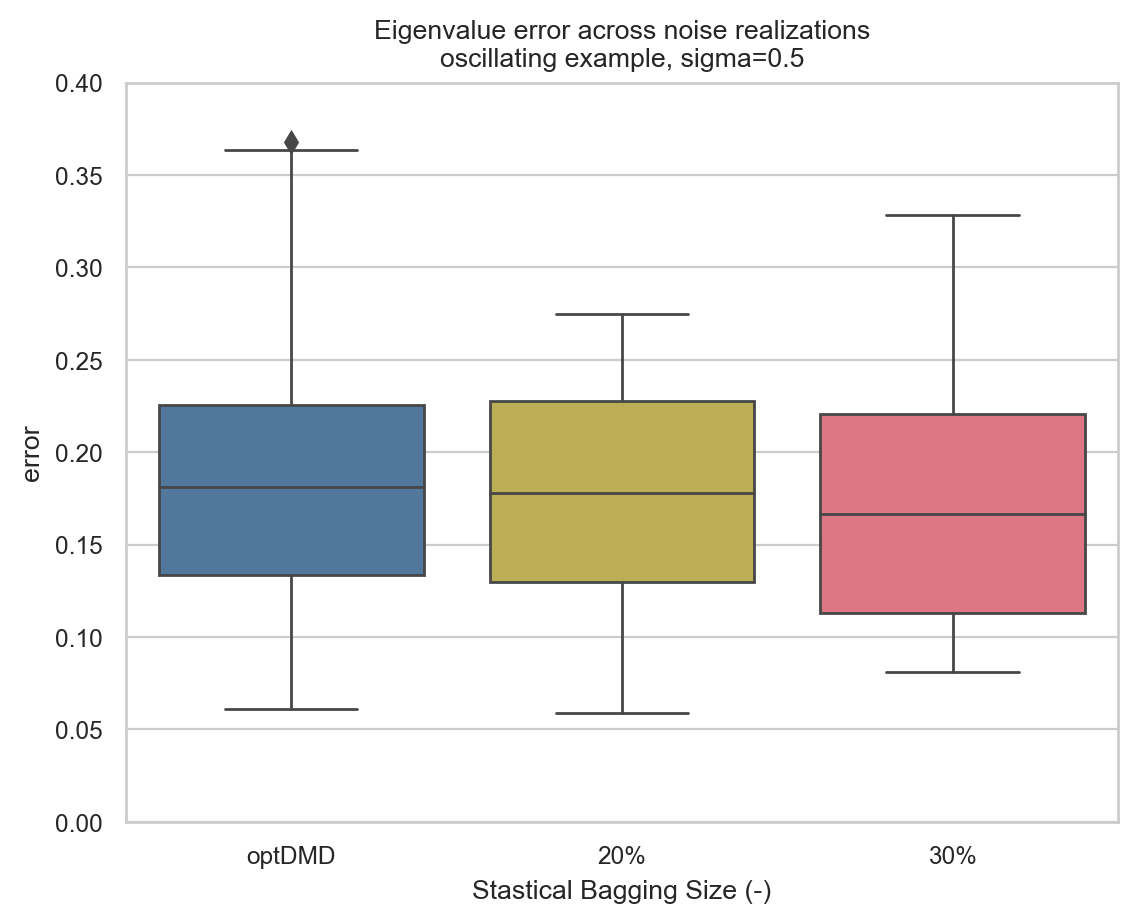

In [149]:
g = sns.boxplot(data=df, linewidth=1, x='p', y='error')
g.set_title('Eigenvalue error across noise realizations\noscillating example, sigma={}'.format(sigma))
g.set_xlabel('Stastical Bagging Size (-)')
g.set_xticklabels(['optDMD', '20%', '30%'])
g.set_ylim(0, 0.4)

# Toy Data: Slow Oscillating Modes

Test that the climatology result is at least generalizable to similar systems.

- With this system we end up finding the same thing: fits depend on the minimum distinguishable time scale. However, this system is limited by distingishuing between an oscillating and decaying modes, with the real component setting the minimally distinguishable time scale.
- Note to self, I've changed this sytem a bit from the original toy data set I devised. The motivation here was to set a system with the real compoonent being the uncertain one.
- The climatology only makes a difference for the imaginary components (oscillating). For instance, a decaying mode here doesn't actually do much past a certain point, which leads to the DMD trying to fit the red noise. For isntance with $\lambda=-0.5 + 0i$

In [138]:
# Generate the synthetic data.

# Set up modes in space.
x0 = 0
x1 = 2 * np.pi
nx = 200

# Space component is evenly spaced.
xspace = np.linspace(x0,x1,nx)

# Set up the spatial modes
f1 = np.sin(xspace)[:, np.newaxis]
f2 = np.cos(xspace)[:, np.newaxis]
f3 = np.tanh(xspace)[:, np.newaxis]

# Set up the time dimension.
t0 = 0
t1 = 6
t2 = t1 + t1 * 0.1
t_extended = int(t1 * 10)
nt = int(100 * t1)
ts = np.linspace(t0, t1, nt, endpoint=False)[np.newaxis, :]
ts_forecast = np.linspace(t1, t2, nt // 10, endpoint=False)[np.newaxis, :]
ts_extended = np.linspace(t0, t_extended, t_extended * 100, endpoint=False)[np.newaxis, :]

# Temporal eigenvalues for each mode
e1 = 0. + 1.7j
e2 = 0 + 2.2j
e3 = 0 - 0.9j
true_eigenvalues = np.array([e1, e2, e3])
# Phase offset of the temporal modes
phase = [0, 0, -np.pi]


# Generate the clean, noiseless dynamics.
xclean = simple_example([f1, f2, f3], true_eigenvalues, ts, phase)
xclean_extended = simple_example([f1, f2, f3], true_eigenvalues, ts_extended, phase)
xclean_forecast = simple_example([f1, f2, f3], true_eigenvalues, ts_forecast, phase)

true_eigenvalues = np.array([e1, e2, e3])

## Visualize

Text(0.5, 0, 'Time Dimension')

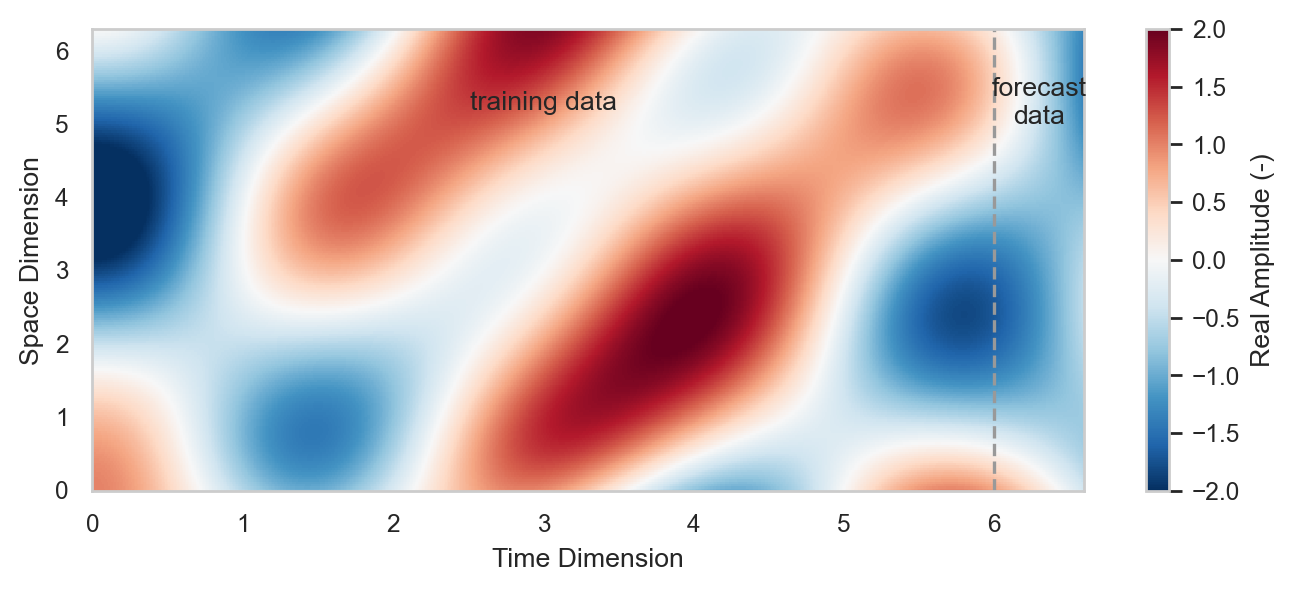

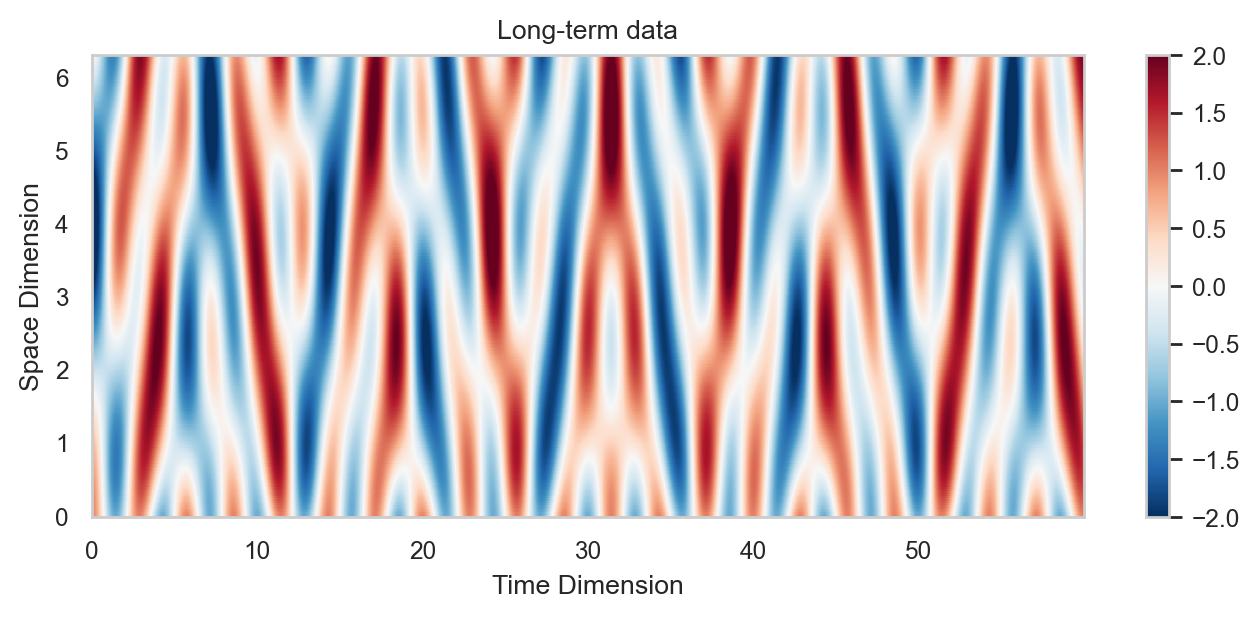

In [139]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
c = ax.pcolormesh(ts, xspace, np.real(xclean), vmin=-2, vmax=2, cmap='RdBu_r')
ax.pcolormesh(ts_forecast, xspace, np.real(xclean_forecast), vmin=-2, vmax=2, cmap='RdBu_r')
ax.text(t0 + (t1 - t0) / 2, xspace.max() - xspace.max() // 5, 'training data',
        horizontalalignment='center',
        verticalalignment='center',
        transform=ax.transData)
ax.axvline(t1, color='0.6', ls='--')
ax.text(t1 + (t2 - t1) / 2, xspace.max() - xspace.max() // 5, 'forecast\ndata',
        horizontalalignment='center',
        verticalalignment='center',
        transform=ax.transData)
cbar = fig.colorbar(c)
cbar.set_label('Real Amplitude (-)')
# ax.set_title('Simple Example')
ax.set_ylabel('Space Dimension')
ax.set_xlabel('Time Dimension')

fig, ax = plt.subplots(1, 1, figsize=(8, 3))
c = ax.pcolormesh(ts_extended, xspace, np.real(xclean_extended), vmin=-2, vmax=2, cmap='RdBu_r')
fig.colorbar(c)
ax.set_title('Long-term data')
ax.set_ylabel('Space Dimension')
ax.set_xlabel('Time Dimension')


Text(0.5, 1.0, 'Temporal Modes of the Toy Data')

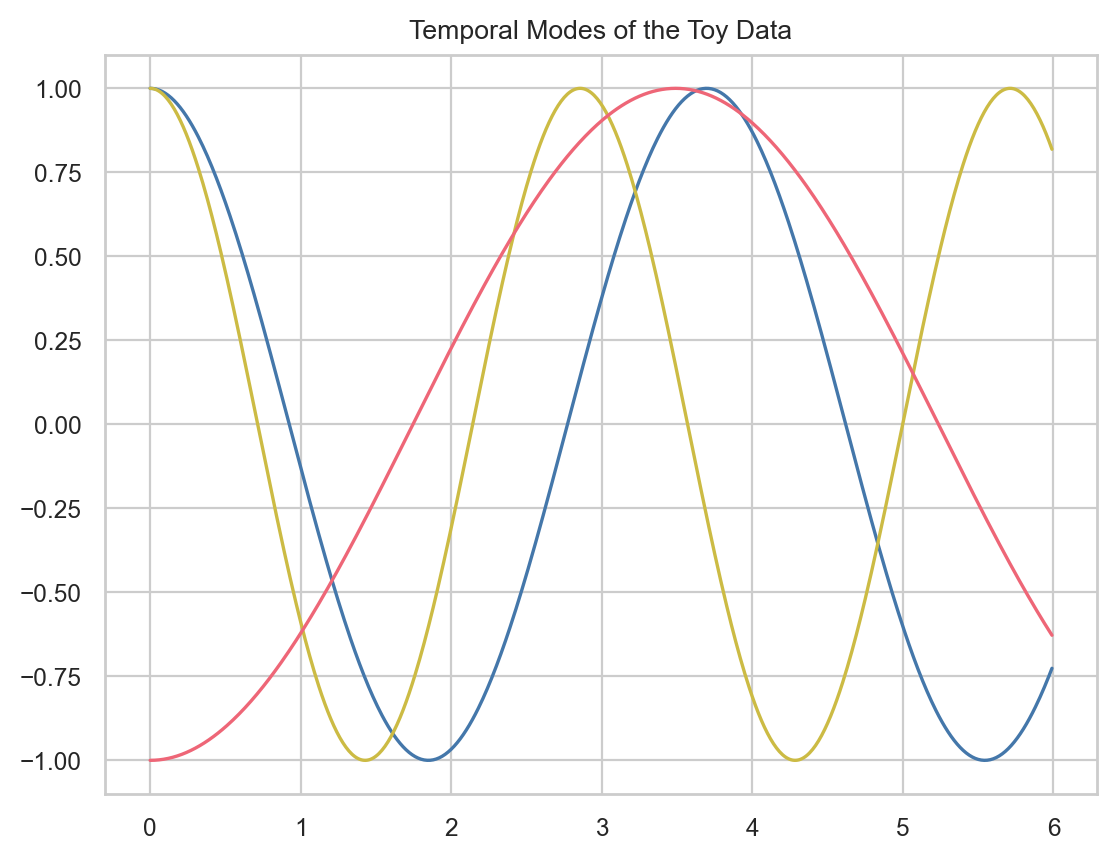

In [140]:
fig, ax = plt.subplots(1, 1)
ax.plot(ts.T, np.real(np.exp(e1 * ts)).T)
ax.plot(ts.T, np.real(np.exp(e2 * ts)).T)
ax.plot(ts.T, np.real(np.exp(e3 * ts - np.pi * 1j)).T)
ax.set_title('Temporal Modes of the Toy Data')

## Fit and Visualize

In [141]:
ds_optdmd, ds_bopdmd, optdmd_container, bopdmd_container = run_noisy_realizations(
    xclean, ts, sigma_array, num_noise_cycles, num_ensembles, ensemble_size, true_eigenvalues, seed=1, red_noise=True, num_modes=4)

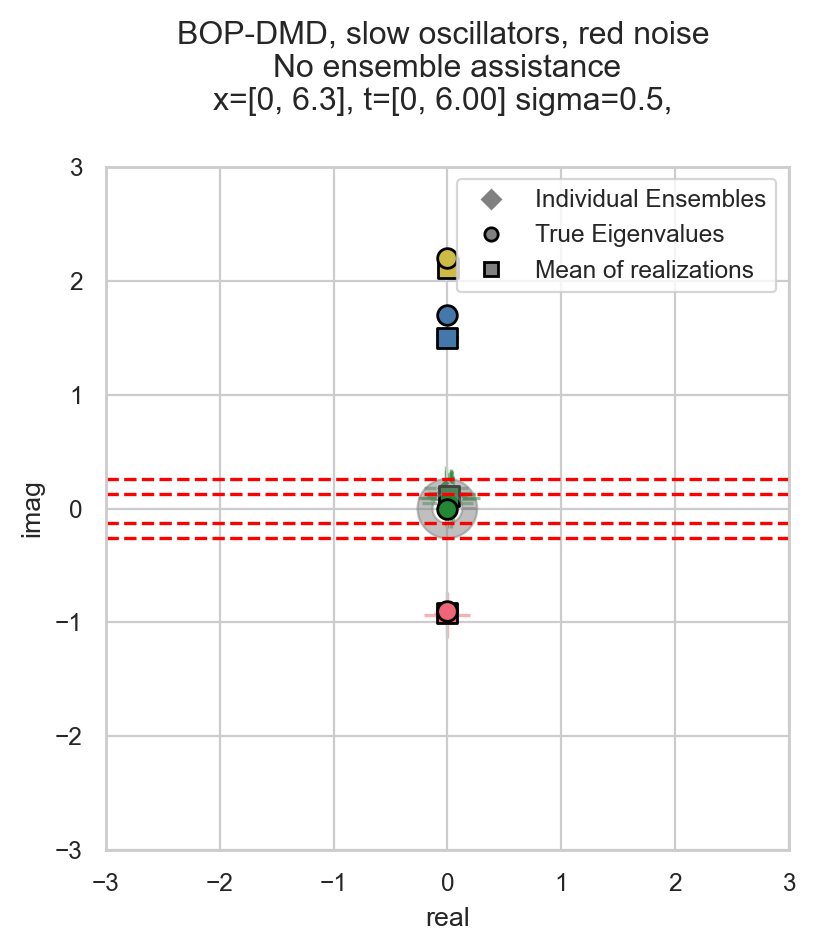

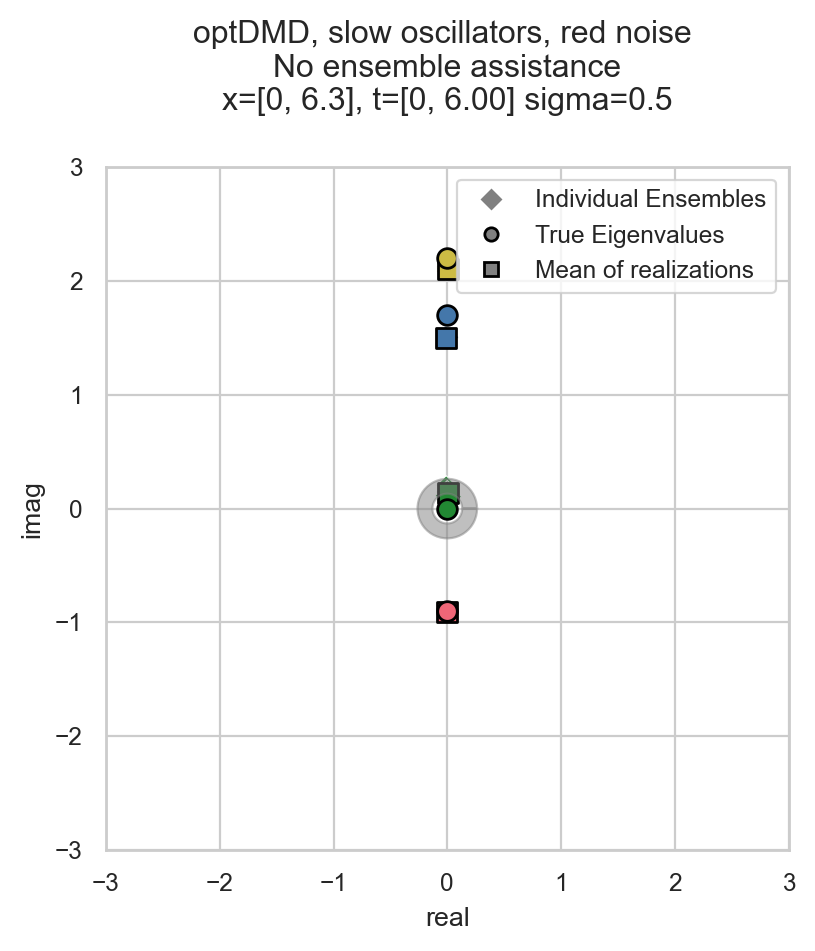

In [142]:
# Distribution plots for the BOP-DMD and optDMD eigenvalues.
radii = [np.pi / (4 * t1), np.pi / (2 * t1)]
xs, ys = certainty_donut(radii)

plt.figure()
for s in ds_bopdmd.sigma:
    g = eigenvalue_scatterplot(ds_bopdmd.sel(sigma=s), true_eigenvalues, lims=(-3, 3))
    plt.gcf().suptitle(
        "BOP-DMD, slow oscillators, red noise \nNo ensemble assistance\nx=[0, {:1.2}], t=[0, {:1.2f}] sigma={}, ".format(x1, t1, s.values))
    plt.gcf().tight_layout()
    g.fill(np.ravel(xs), np.ravel(ys), edgecolor='k', color='0.5', alpha=0.5)
    g.axhline(radii[0], color='r', ls='--')
    g.axhline(radii[1], color='r', ls='--')
    g.axhline(-radii[0], color='r', ls='--')
    g.axhline(-radii[1], color='r', ls='--')
    
plt.figure()
for s in ds_bopdmd.sigma:
    g = eigenvalue_scatterplot(ds_optdmd.sel(sigma=s), true_eigenvalues, lims=(-3, 3))
    plt.gcf().suptitle(
        "optDMD, slow oscillators, red noise \nNo ensemble assistance\nx=[0, {:1.2}], t=[0, {:1.2f}] sigma={}".format(x1, t1, s.values))
    plt.gcf().tight_layout()
    g.fill(np.ravel(xs), np.ravel(ys), edgecolor='k', color='0.5', alpha=0.5)

## Using climatology

In [143]:
# Give weakly informative priors for the long-term mean.
lt_length = 10
lt_mean = np.zeros((nx, lt_length))
# ts_lt = np.array([np.arange(t1 * 10, t1 * 10 + lt_length)])

dt = int(nt)
block_subdivision = 5
num_block_time_offset = 20
block_size = dt // block_subdivision
offset = num_block_time_offset * block_size

# Keep the space dimension, create a new dimension for the block, and make each block the appropriate width
lt_climatology = xclean_extended.reshape((xclean_extended.shape[0], -1, block_size)).mean(axis=-1)[:, block_subdivision + num_block_time_offset:]

# Set this long term mean to be far in the future.
# ts_lt = np.atleast_2d(ts_extended[:, slice(-lt_length * dt, None, dt)])
ts_lt = ts_extended[:, int(nt + dt // (block_subdivision * 2)) + offset::int(block_size)]

Text(0.5, 1.0, 'Data with climatological priors')

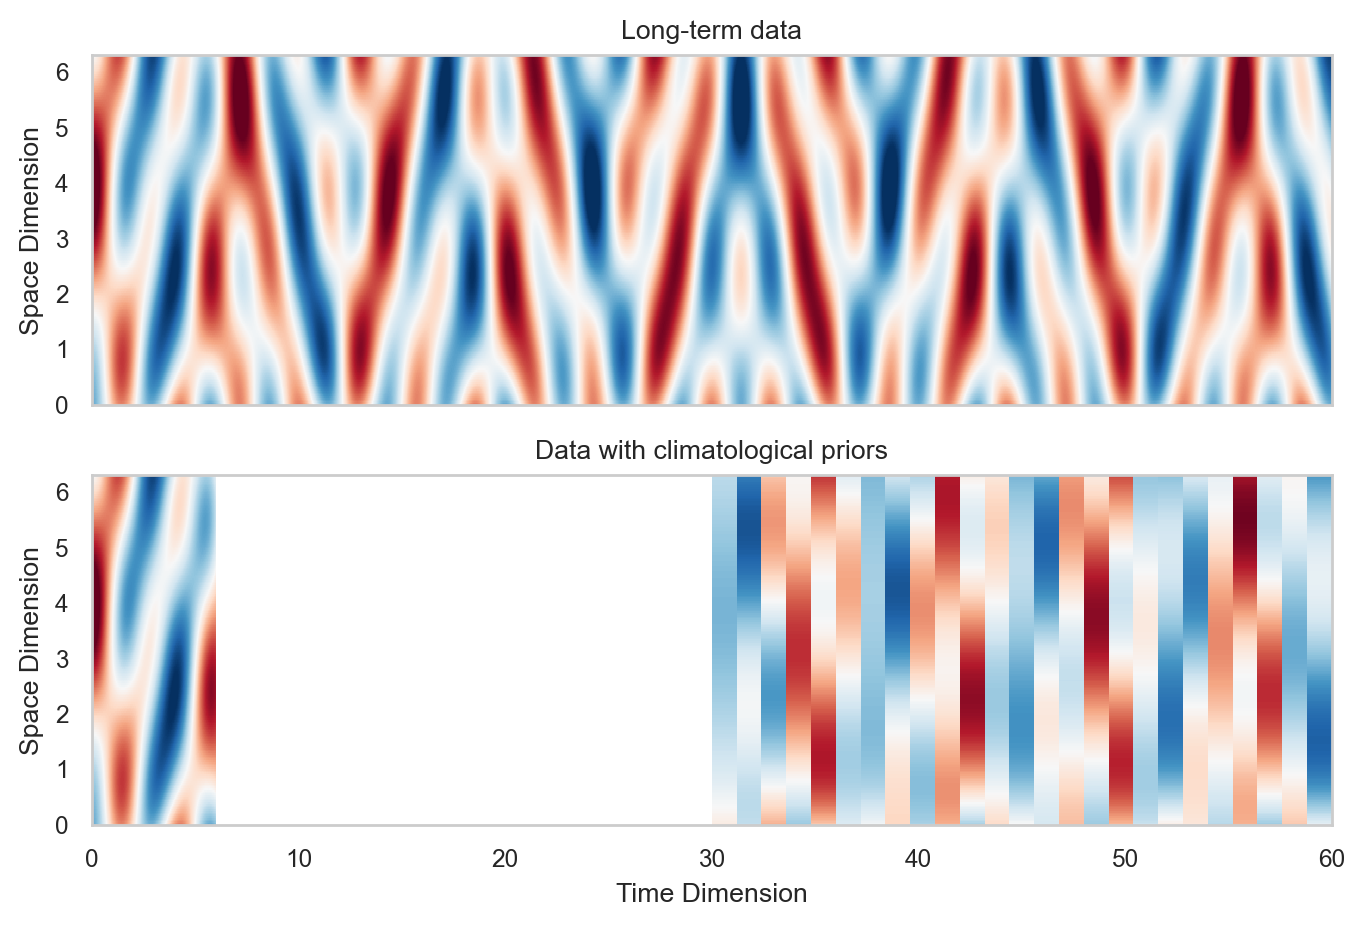

In [144]:
fig, axes = plt.subplots(2, 1, figsize=(8, 5), sharex=True)

ax = axes[0]
c = ax.pcolormesh(ts_extended, xspace, np.real(xclean_extended), vmin=-2, vmax=2, cmap='RdBu')
# fig.colorbar(c)
ax.set_title('Long-term data')
ax.set_ylabel('Space Dimension')

ax = axes[1]
ax.pcolormesh(ts_lt, xspace, np.real(lt_climatology), vmin=-2, vmax=2, cmap='RdBu')
ax.pcolormesh(ts, xspace, np.real(xclean), vmin=-2, vmax=2, cmap='RdBu')
ax.set_xlabel('Time Dimension')
ax.set_ylabel('Space Dimension')
ax.set_title('Data with climatological priors')


## Climatology

In [148]:
( ds_optdmd_climatology, ds_bopdmd_climatology, optdmd_container_climatology, bopdmd_container_climatology
) = run_noisy_realizations(
    xclean, ts, sigma_array, num_noise_cycles, num_ensembles, ensemble_size,
    true_eigenvalues[0:3], seed=1, ts_longterm=ts_lt, data_longterm=lt_climatology,
    red_noise=True, num_modes=3,
)

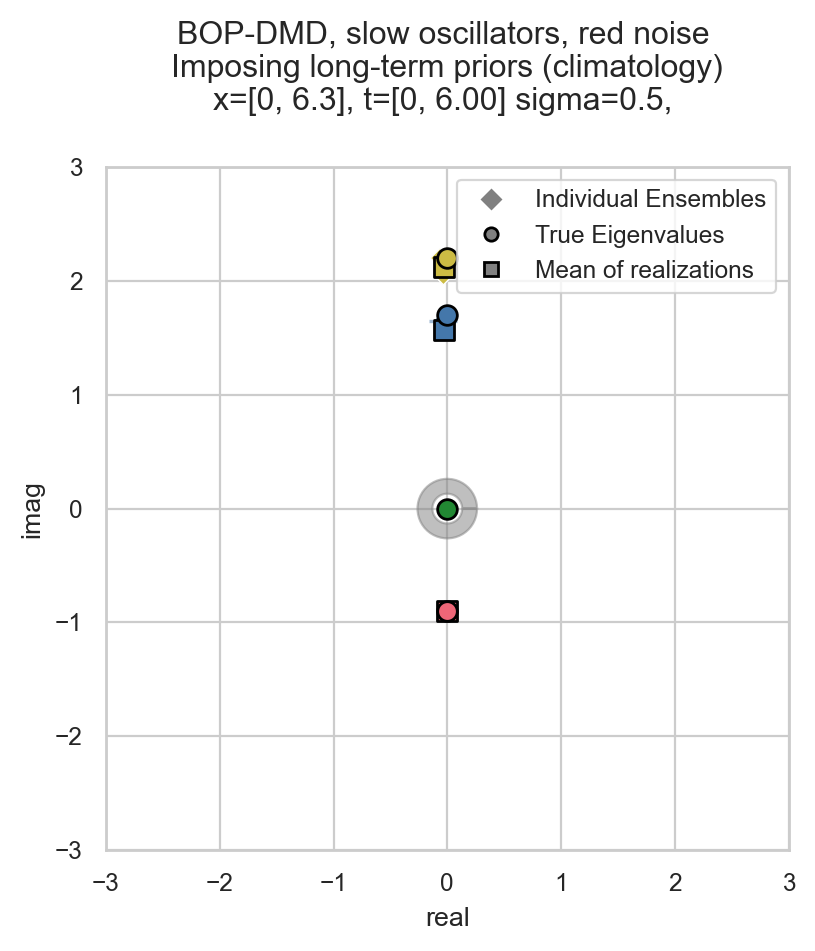

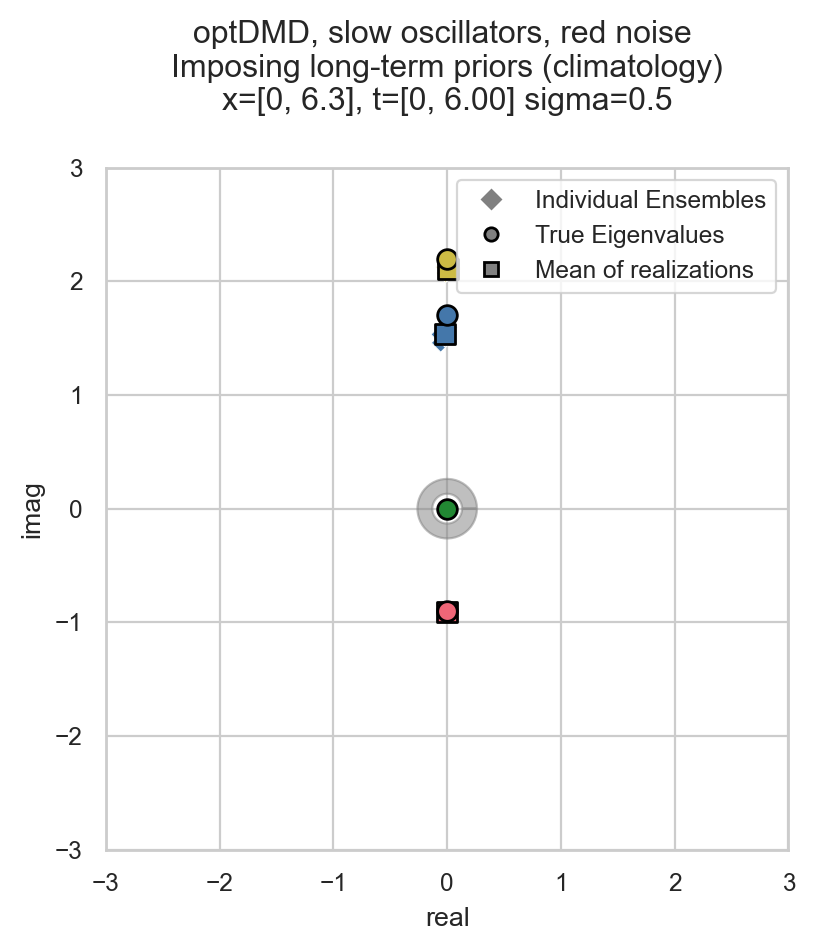

In [149]:
# Distribution plots for the BOP-DMD and optDMD eigenvalues.
radii = [np.pi / (4 * t1), np.pi / (2 * t1)]
xs, ys = certainty_donut(radii)

plt.figure()
for s in ds_bopdmd.sigma:
    g = eigenvalue_scatterplot(ds_bopdmd_climatology.sel(sigma=s), true_eigenvalues, lims=(-3, 3))
    plt.gcf().suptitle(
        "BOP-DMD, slow oscillators, red noise \nImposing long-term priors (climatology)\nx=[0, {:1.2}], t=[0, {:1.2f}] sigma={}, ".format(x1, t1, s.values))
    plt.gcf().tight_layout()
    g.fill(np.ravel(xs), np.ravel(ys), edgecolor='k', color='0.5', alpha=0.5)

plt.figure()
for s in ds_bopdmd.sigma:
    g = eigenvalue_scatterplot(ds_optdmd_climatology.sel(sigma=s), true_eigenvalues, lims=(-3, 3))
    plt.gcf().suptitle(
        "optDMD, slow oscillators, red noise \nImposing long-term priors (climatology)\nx=[0, {:1.2}], t=[0, {:1.2f}] sigma={}".format(x1, t1, s.values))
    plt.gcf().tight_layout()
    g.fill(np.ravel(xs), np.ravel(ys), edgecolor='k', color='0.5', alpha=0.5)

Derive and evaluate the actual error.

<AxesSubplot: xlabel='eigenvalue', ylabel='real_std'>

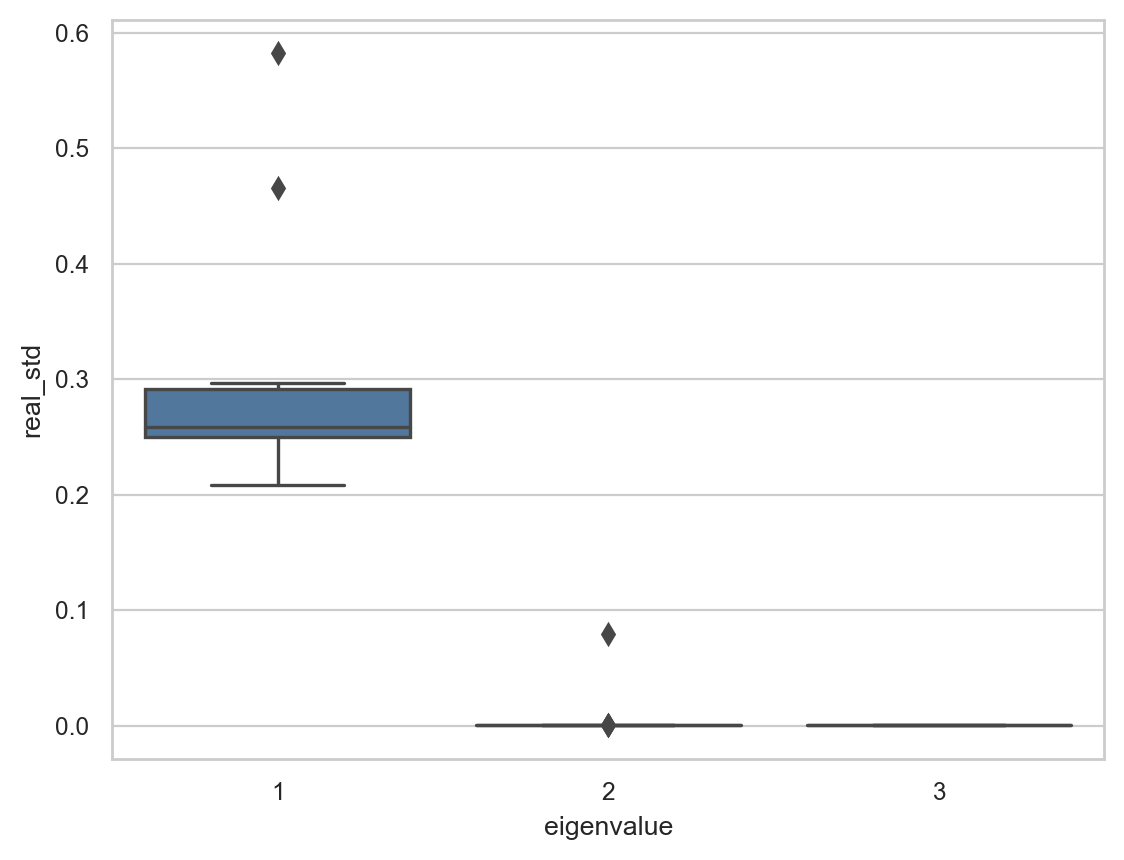

In [108]:
ds_bopdmd_climatology.drop(['noise realization'])
df = ds_bopdmd_climatology.real_std.to_dataframe().droplevel(0).reset_index()
sns.boxplot(data=df, x='eigenvalue', y='real_std')

In [109]:
ds_bopdmd_climatology

<xarray.Dataset>
Dimensions:            (noise realization: 10, eigenvalue: 3, sigma: 1)
Coordinates:
  * noise realization  (noise realization) int64 0 1 2 3 4 5 6 7 8 9
  * eigenvalue         (eigenvalue) object '1' '2' '3'
  * sigma              (sigma) float64 0.5
Data variables:
    real               (noise realization, eigenvalue) float64 -0.2725 ... -0...
    imag               (noise realization, eigenvalue) float64 1.328 ... -0.8998
    real_std           (noise realization, eigenvalue) float64 0.2536 ... 0.0...
    imag_std           (noise realization, eigenvalue) float64 0.0 0.0 ... 0.0